---
title: Integrating air microbiome for comprehensive air quality analysis
subtitle: An evaluation of the potential of HVS for airborne microbiome monitoring

authors:
  - name: "Alejandro Fontal"
    affiliation: "AIRLAB, Climate and Health Programme, ISGlobal, Barcelona, Spain"
    affiliation-url: "https://www.isglobal.org/en/-/clima-y-salud"
    email: "alejandro.fontal.92@gmail.com"
    url: "https://alfontal.dev"
    orcid: 0000-0003-1138-2158

date: "last-modified"

format:
  html:
    warning: false
    smooth-scroll: true
    toc: true
    toc-location: right
    number-sections: false

---

 In this report, we will perform part of the analysis and generate some of the figures for the manuscript _Integrating air microbiome for comprehensive air quality analysis_.

 For easier reading, most code cells have been hidden by default, but you can expand them by clicking on the "Show code" button above each cell. The full code should be possible to run in a local environment top to bottom.


#### Preamble {-}

<details>
<summary>Show code imports and presets</summary>

<br>
In this section we load the necessary libraries and set the global parameters for the
notebook. It's irrelevant for the narrative of the analysis but essential for the 
reproducibility of the results.

##### Imports {-}

In [1]:
import os

import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.colors
import scipy.stats as stats
import matplotlib.pyplot as plt

from IPython.display import Image
from mizani.formatters import percent_format

##### Pre-sets {-}

In [2]:
# Matplotlib settings
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['svg.fonttype'] = 'none'
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300

# Plotnine settings (for figures)

p9.options.set_option('base_family', 'Georgia')

p9.theme_set(
    p9.theme_bw()
    + p9.theme(panel_grid=p9.element_blank(),
               legend_background=p9.element_blank(),
               panel_grid_major=p9.element_line(size=.5, linetype='dashed',
                                                alpha=.15, color='black'),
               plot_title=p9.element_text(ha='center'),
               dpi=300
    )
)

separator_line =  p9.annotate(
    geom='line',
    linetype='dashed',
    size=.2,
    x=[137, 144],
    y= [31, 36],
  )

## Data loading and wrangling

We will start by loading the medatata file which we have stored in `/data/meta.txt` with
information about each sample:

In [3]:
metadata_df = pd.read_table('../data/meta.txt', sep='\t')
metadata_df.head()

Sample Name  Sample Number AirLab_Code Seq ID Sample ID  \
0  2022/11/23HVS-SASS-PilotA1              1      T6.0 B  HVSP1      C6-B   
1  2022/11/28HVS-SASS-PilotA2              2      T6.1 B  HVSP2    D6.1-B   
2  2022/11/28HVS-SASS-PilotA3              3      T6.2 B  HVSP3    D6.2-B   
3  2022/11/28HVS-SASS-PilotA4              4      T6.3 B  HVSP4    D6.3-B   
4  2022/11/28HVS-SASS-PilotA5              5      T6.4 B  HVSP5    D6.4-B   

     Sampling    Project Name        Location Relative Location  \
0  Continuous  HVS-SASS-Pilot  AirLab Terrace           Outdoor   
1    Discrete  HVS-SASS-Pilot  AirLab Terrace           Outdoor   
2    Discrete  HVS-SASS-Pilot  AirLab Terrace           Outdoor   
3    Discrete  HVS-SASS-Pilot  AirLab Terrace           Outdoor   
4    Discrete  HVS-SASS-Pilot  AirLab Terrace           Outdoor   

      Media Type  ...     Entered By DNA Extraction Date (YYYY-MM-DD)  \
0  Quartz Filter  ...  Cassie Heinle                       28/11/2022   
1  Quartz Filter  ...  Cassie Heinle                       28/11/2022   
2  Quartz Filter  ...  Cassie Heinle                       28/11/2022   
3  Quartz Filter  ...  Cassie Heinle                       28/11/2022   
4  Quartz Filter  ...  Cassie Heinle                       28/11/2022   

               DNA Extraction Kit  DNA Concentration (ng/uL)  \
0  Phe-Chlo method (AirLab Spain)                       7133   
1  Phe-Chlo method (AirLab Spain)                        856   
2  Phe-Chlo method (AirLab Spain)                       1193   
3  Phe-Chlo method (AirLab Spain)                       1483   
4  Phe-Chlo method (AirLab Spain)                        111   

   DNA Volume of Elution (uL)   DNA Quantification Instrument  \
0                          17  Quantus Promega (AirLab Spain)   
1                          17  Quantus Promega (AirLab Spain)   
2                          17  Quantus Promega (AirLab Spain)   
3                          17  Quantus Promega (AirLab Spain)   
4                          17  Quantus Promega (AirLab Spain)   

  DNA Vol. Used for Quantification (uL)     DNA Storage Freezer  \
0                                     5  -20C MPL Freezer (New)   
1                                     5  -20C MPL Freezer (New)   
2                                     5  -20C MPL Freezer (New)   
3                                     5  -20C MPL Freezer (New)   
4                                     5  -20C MPL Freezer (New)   

  DNA Storage Drawer DNA Performed By  
0            Yee Hui     AirLab Spain  
1            Yee Hui     AirLab Spain  
2            Yee Hui     AirLab Spain  
3            Yee Hui     AirLab Spain  
4            Yee Hui     AirLab Spain  

[5 rows x 28 columns]

In [4]:
metadata_df = (metadata_df
 .drop(columns=metadata_df.nunique().loc[lambda x: x==1].index)
 .rename(columns={'Seq ID': 'sample_id'})

)

We also have the total number of reads for each assigned Species for all samples, which we will load from `/data/REL_hvsp_sp.txt`

In [5]:
species_df = pd.read_table('../data/REL_hvsp_sp.txt')

We have been given a list of species that are considered to be contaminants, which 
we will remove from the analysis:

In [6]:
contamination_list = [
    "Galendromus occidentalis", 
    "Bemisia tabaci", 
    "Candidatus Portiera aleyrodidarum", 
    "Frankliniella occidentalis", 
    "Thrips palmi"
]

Information on the total DNA yield of each sample is stored in the `/data/DNA.xlsx` file:

In [7]:
dna_yields = (pd.read_excel('../data/DNA.xlsx')
 .rename(columns={
    'DNA Concentration (ng/uL)': 'dna_conc',
    'DNA Volume of Elution (uL)': 'dna_vol',
    'Sample ID': 'sample_code'
 })
 .assign(dna_yield=lambda x: x['dna_conc'] * x['dna_vol'])
 [['sample_code', 'dna_yield']]
)

We will generate a long-form dataframe with the species counts for each sample:

In [8]:
species_long = (species_df
 .rename(columns={'#Datasets': 'name'})
 .melt('name', var_name='sample_id', value_name='reads')
 .assign(sample_id=lambda x: x['sample_id'].str.split('.').str[0])
 .query('name not in @contamination_list')
 .query('reads > 0')
)
species_long.sample(10)

name sample_id  reads
128710        Krasilnikoviella flava    HVSP15   25.0
337027       Marmoricola sp. Leaf446    HVSP45  599.0
49047          Limibaculum sp. M0105     HVSP6   33.0
157388       Nocardioides ungokensis    HVSP19  148.0
269015    Rubripirellula reticaptiva    HVSP35   28.0
167215      Streptomyces hoynatensis    HVSP20   40.0
23868             Georgenia subflava     HVSP3  115.0
461309  Jeotgalicoccus psychrophilus    HVSP59  133.0
403987         Rubrobacter aplysinae    HVSP53   81.0
208014          Phyllostachys edulis    HVSP26   28.0

### Experiment 1: Continuous vs Discrete sampling

Let's start by taking a look at how the DNA yield of the samples and the diversity
(measured as the richness of species) compares:

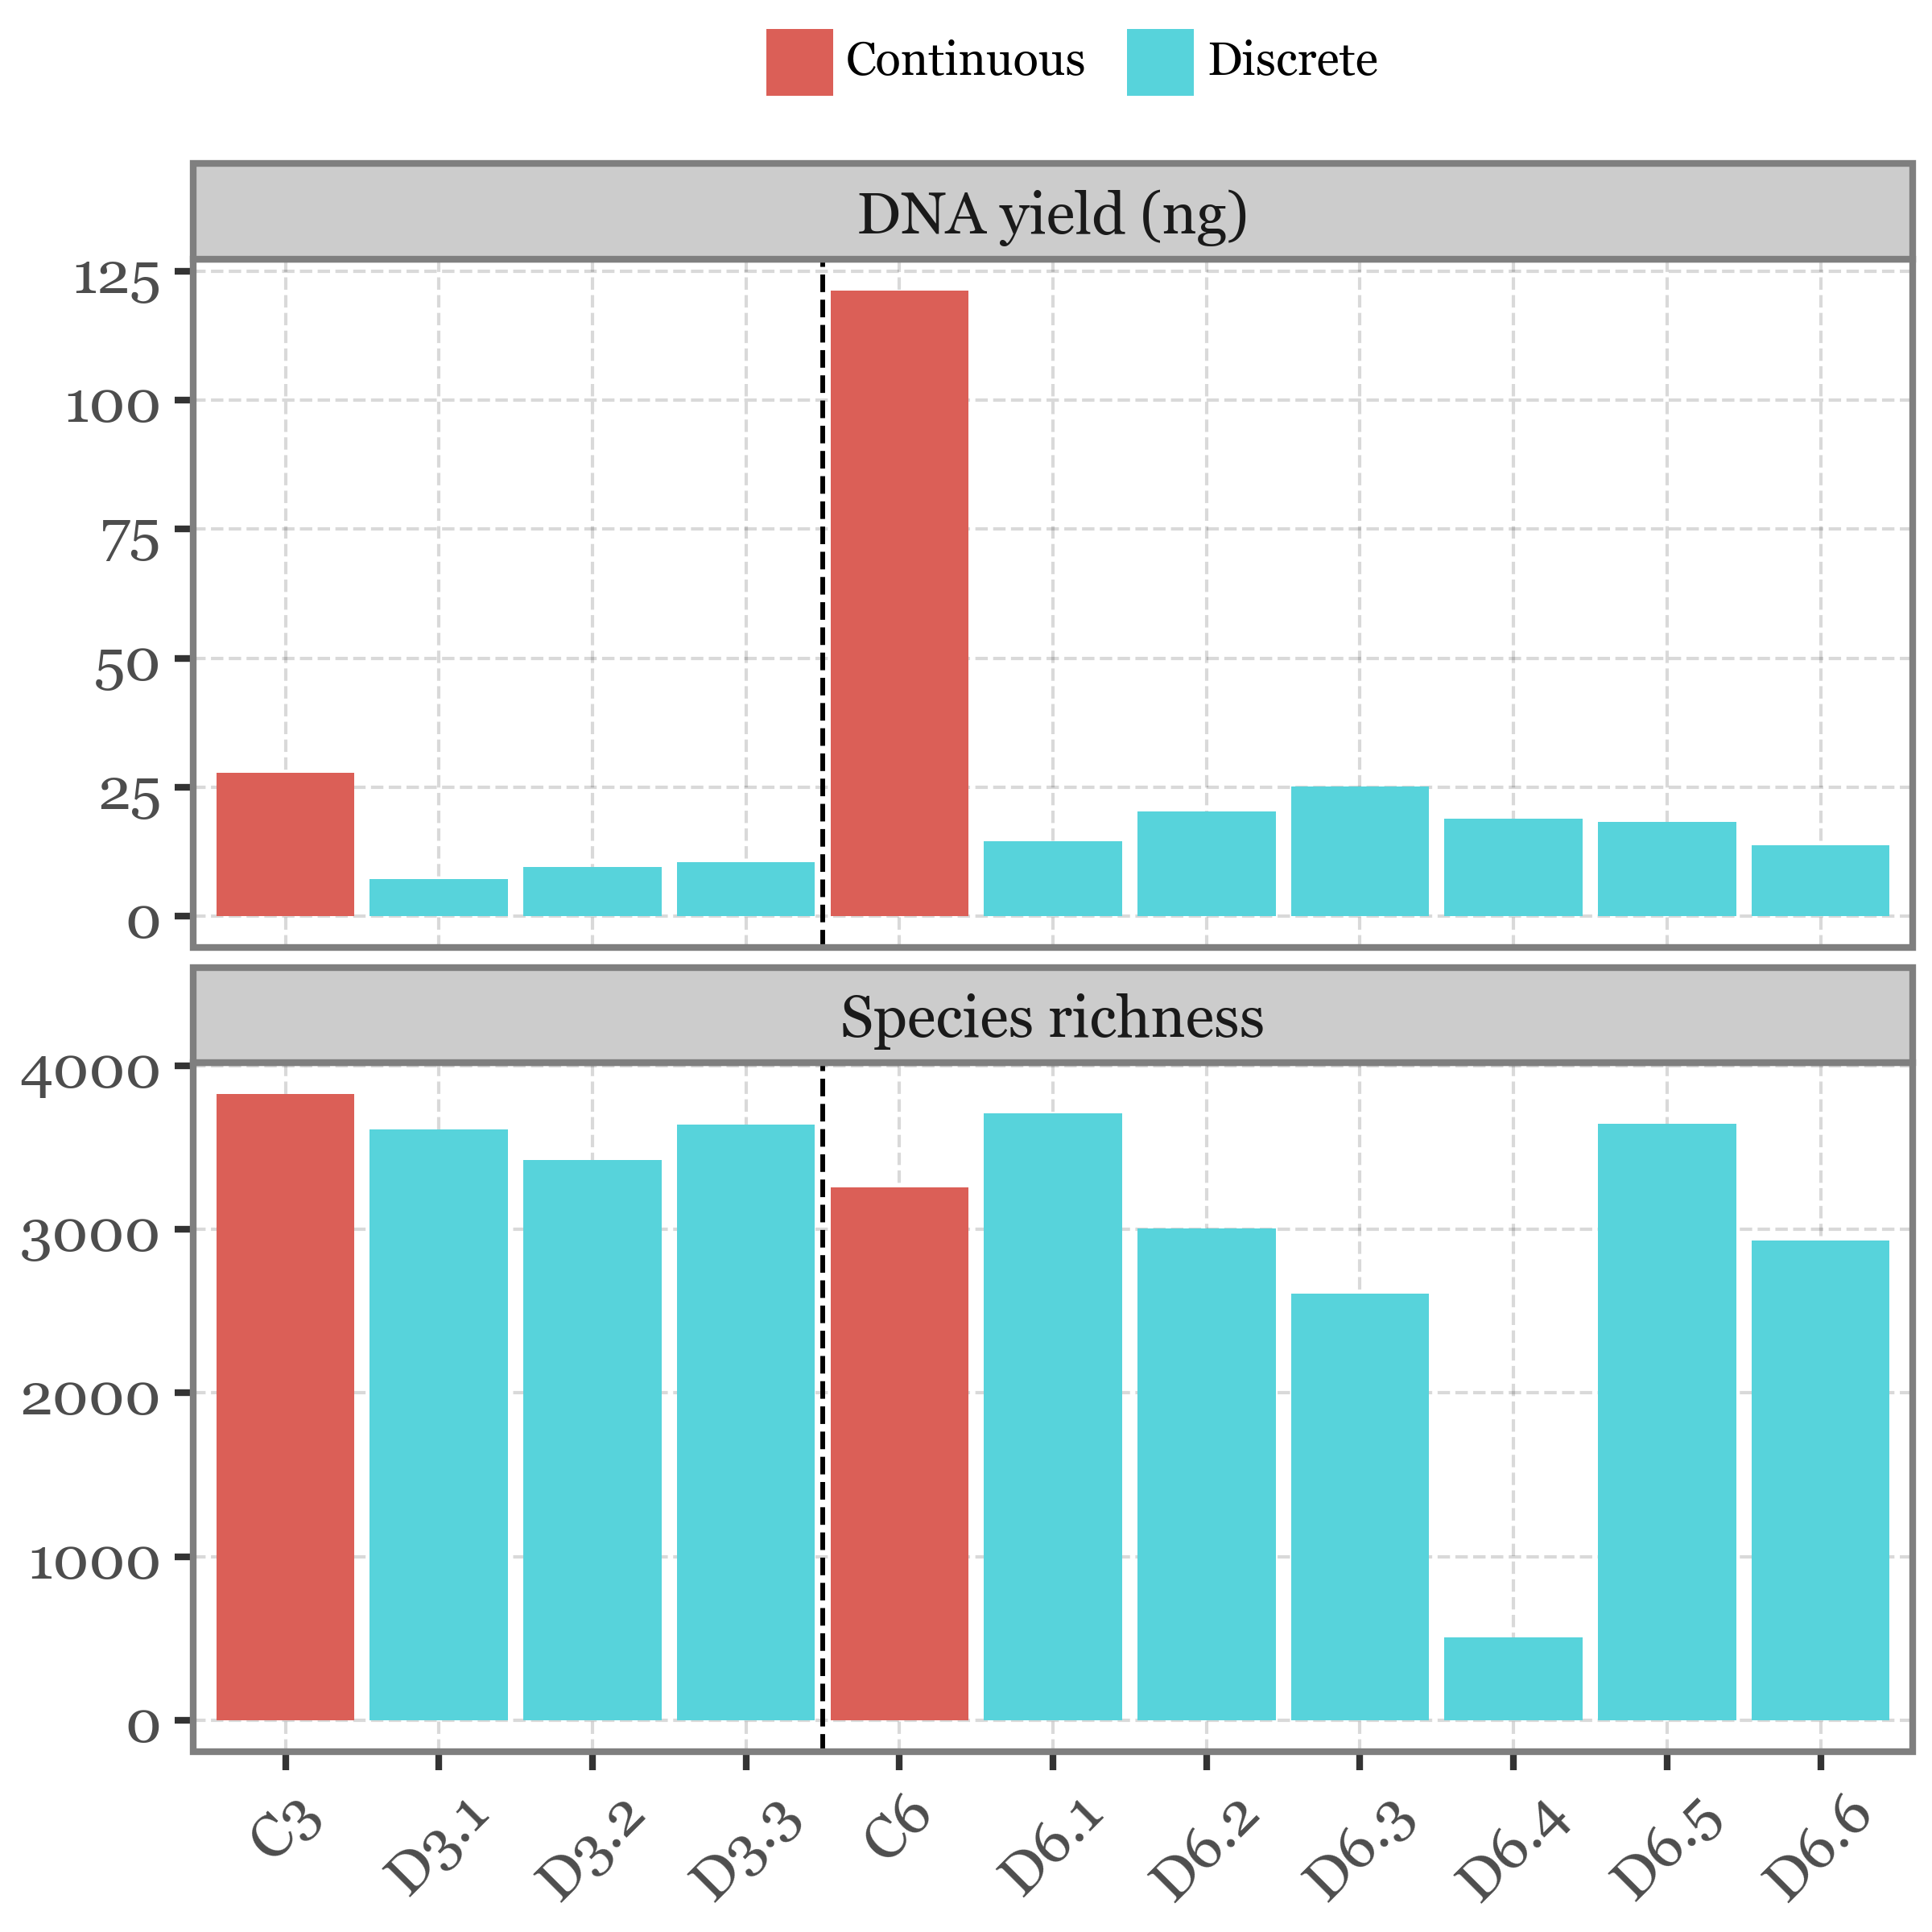

In [9]:
#| code-fold: true

exp_1_samples = ['C3-B', 'D3.1-B', 'D3.2-B', 'D3.3-B', 'C6-B', 'D6.1-B', 'D6.2-B',
                  'D6.3-B', 'D6.4-B', 'D6.5-B', 'D6.6-B',]
exp1_names = [s.split('-')[0] for s in exp_1_samples]
exp_1_meta = (metadata_df
 .query('`Sample ID` in @exp_1_samples')
 .assign(sampling_days=lambda x: x['Sample ID'].str[1])
 .rename(columns={'Sample ID': 'sample_code', 'Sampling': 'mode'})
 [['sample_id', 'sample_code', 'mode', 'sampling_days']]
 .merge(dna_yields, on='sample_code')
)

(species_long
 .query('reads > 0')
 .groupby('sample_id')
 .size()
 .reset_index(name='richness')
 .merge(exp_1_meta)
 .assign(sample_code=lambda dd: dd.sample_code.str.split('-').str[0])
 .assign(sample_code=lambda dd: 
         pd.Categorical(dd.sample_code, categories=exp1_names, ordered=True))
 .melt(id_vars=['sample_id', 'sample_code', 'mode', 'sampling_days'])
 .replace({'richness': 'Species richness', 'dna_yield': 'DNA yield (ng)'})
 .pipe(lambda x: p9.ggplot(x) 
       + p9.aes(x='sample_code', y='value', fill='mode')
       + p9.geom_col()
       + p9.facet_wrap('~variable', scales='free_y', ncol=1)
       + p9.annotate('vline', xintercept=[4.5], linetype='dashed', size=.4)
       + p9.labs(x='', y='', fill='')
       + p9.theme(
           figure_size=(4, 4),
           axis_text_x=p9.element_text(angle=45),
           legend_position='top',
           legend_key_size=10,
           legend_text=p9.element_text(size=7),
           )
       )
)

At a simple glance, it seems that the continuous sampling method yields more DNA (which
makes sense since they are sampling for longer periods of time) but this does not seem to
translate into a higher species richness.

If we now check not only the richness but the actual species belonging to each of 
the sample types and see whether some species are more common in one type of sample than
the other: 

/var/folders/st/cmjs4m0d5_x9cct52wfljtvm0000gn/T/ipykernel_34421/1407548480.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/st/cmjs4m0d5_x9cct52wfljtvm0000gn/T/ipykernel_34421/1407548480.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


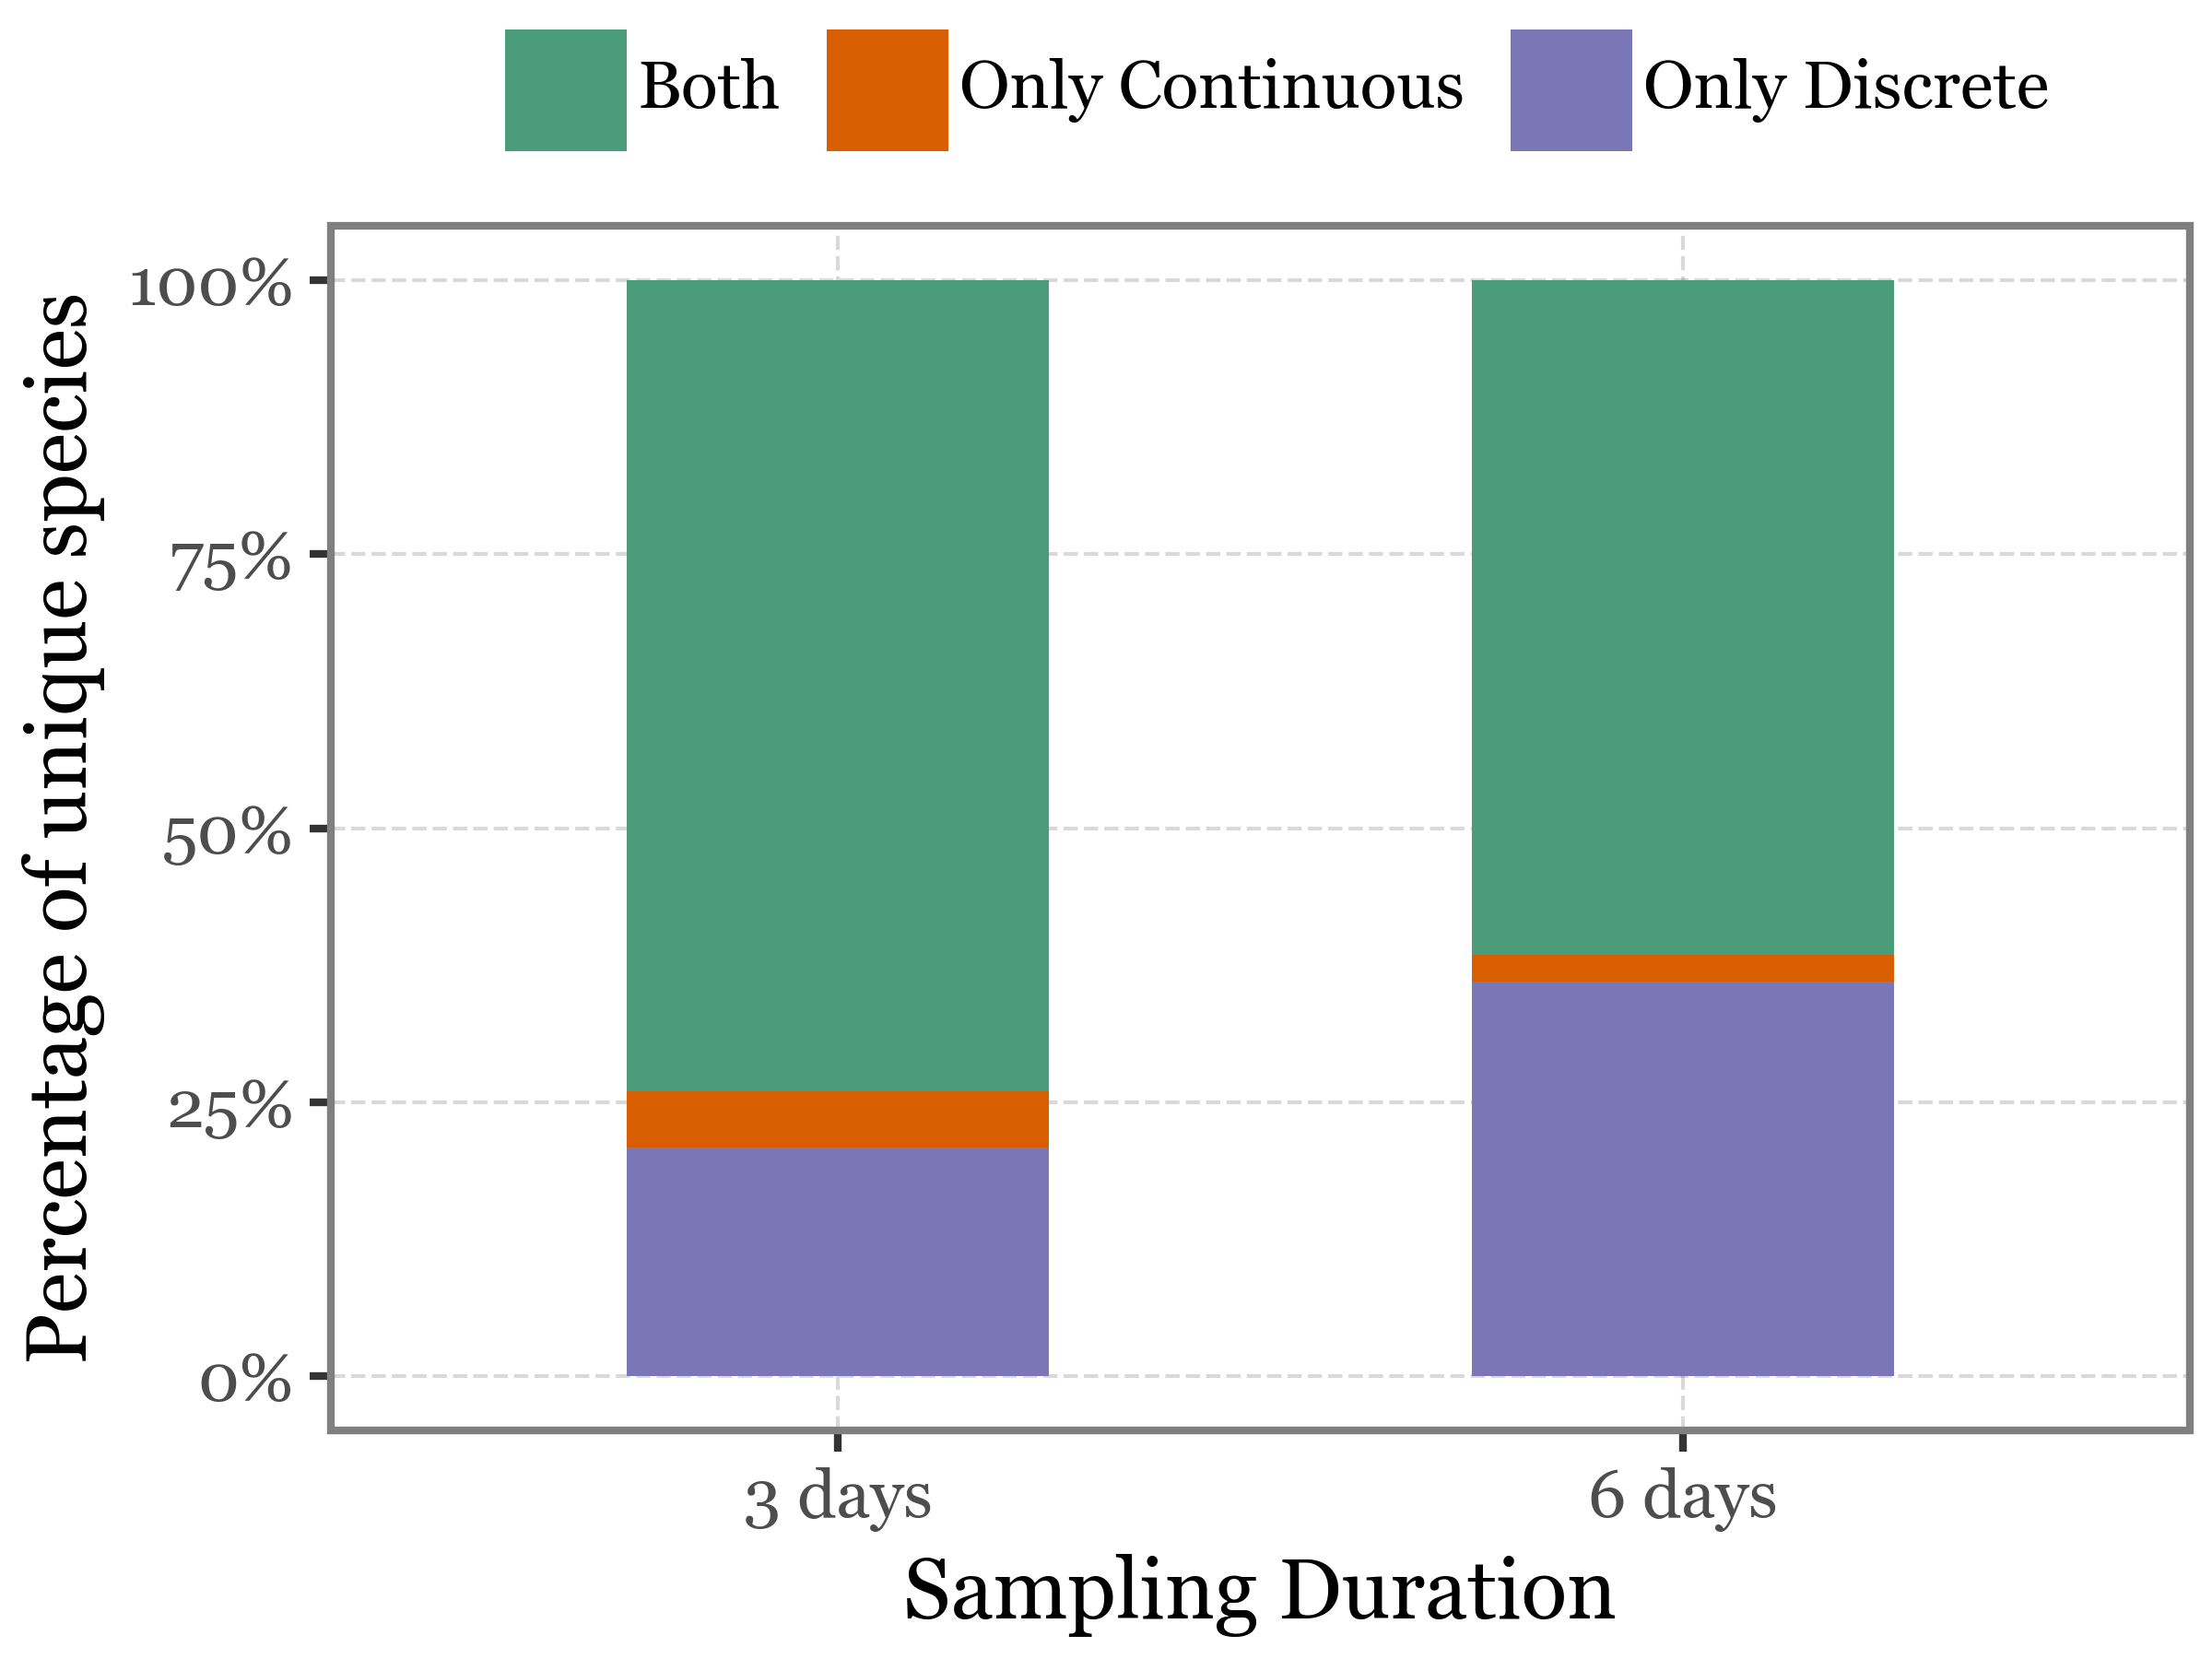

In [10]:
#| code-fold: true

table_3 = (species_long
 .merge(exp_1_meta)
 .query('sampling_days.notna()')
 .query('reads > 0')
 .query('sampling_days == "3"')
 .groupby(['name', 'mode', 'sampling_days'])
 ['reads']
 .sum()
 .reset_index()
 .pivot(index='name', columns=['mode'], values='reads')
 .fillna(0)
 .loc[lambda x: x.sum(axis=1) > 0]
 .applymap(lambda x: x > 0)
 .assign(presence=lambda dd: 
         np.where(dd['Continuous'] == dd['Discrete'], 'Both',
         np.where(dd['Continuous'], 'Only Continuous', 'Only Discrete'))
         )
 .dropna()
 .groupby(['presence'])
 .size()
 .reset_index()
 .rename(columns={0:'richness'})
 .assign(freq=lambda dd: dd['richness'] / dd['richness'].sum())
 .assign(days="3 days")
 )

table_6 = (species_long
 .merge(exp_1_meta)
 .query('sampling_days.notna()')
 .query('reads > 0')
 .query('sampling_days == "6"')
 .groupby(['name', 'mode', 'sampling_days'])
 ['reads']
 .sum()
 .reset_index()
 .pivot(index='name', columns=['mode'], values='reads')
 .fillna(0)
 .loc[lambda x: x.sum(axis=1) > 0]
 .applymap(lambda x: x > 0)
 .assign(presence=lambda dd: 
         np.where(dd['Continuous'] == dd['Discrete'], 'Both',
         np.where(dd['Continuous'], 'Only Continuous', 'Only Discrete'))
         )
 .dropna()
 .groupby(['presence'])
 .size()
 .reset_index()
 .rename(columns={0:'richness'})
 .assign(freq=lambda dd: dd['richness'] / dd['richness'].sum())
 .assign(days="6 days")
 )


(pd.concat([table_3, table_6])
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('days', 'freq')
       + p9.geom_col(p9.aes(fill='presence'), width=.5)
       + p9.scale_y_continuous(labels=percent_format())
       + p9.scale_fill_manual(['#4B9C78', '#D85E01', '#7B76B5'
           
       ])
       + p9.labs(x='Sampling Duration', y='Percentage of unique species', fill='')
       + p9.theme(figure_size=(4, 3),
                  legend_position='top'
                  )


 )
       )

If we represent the same information in a Sankey diagram:

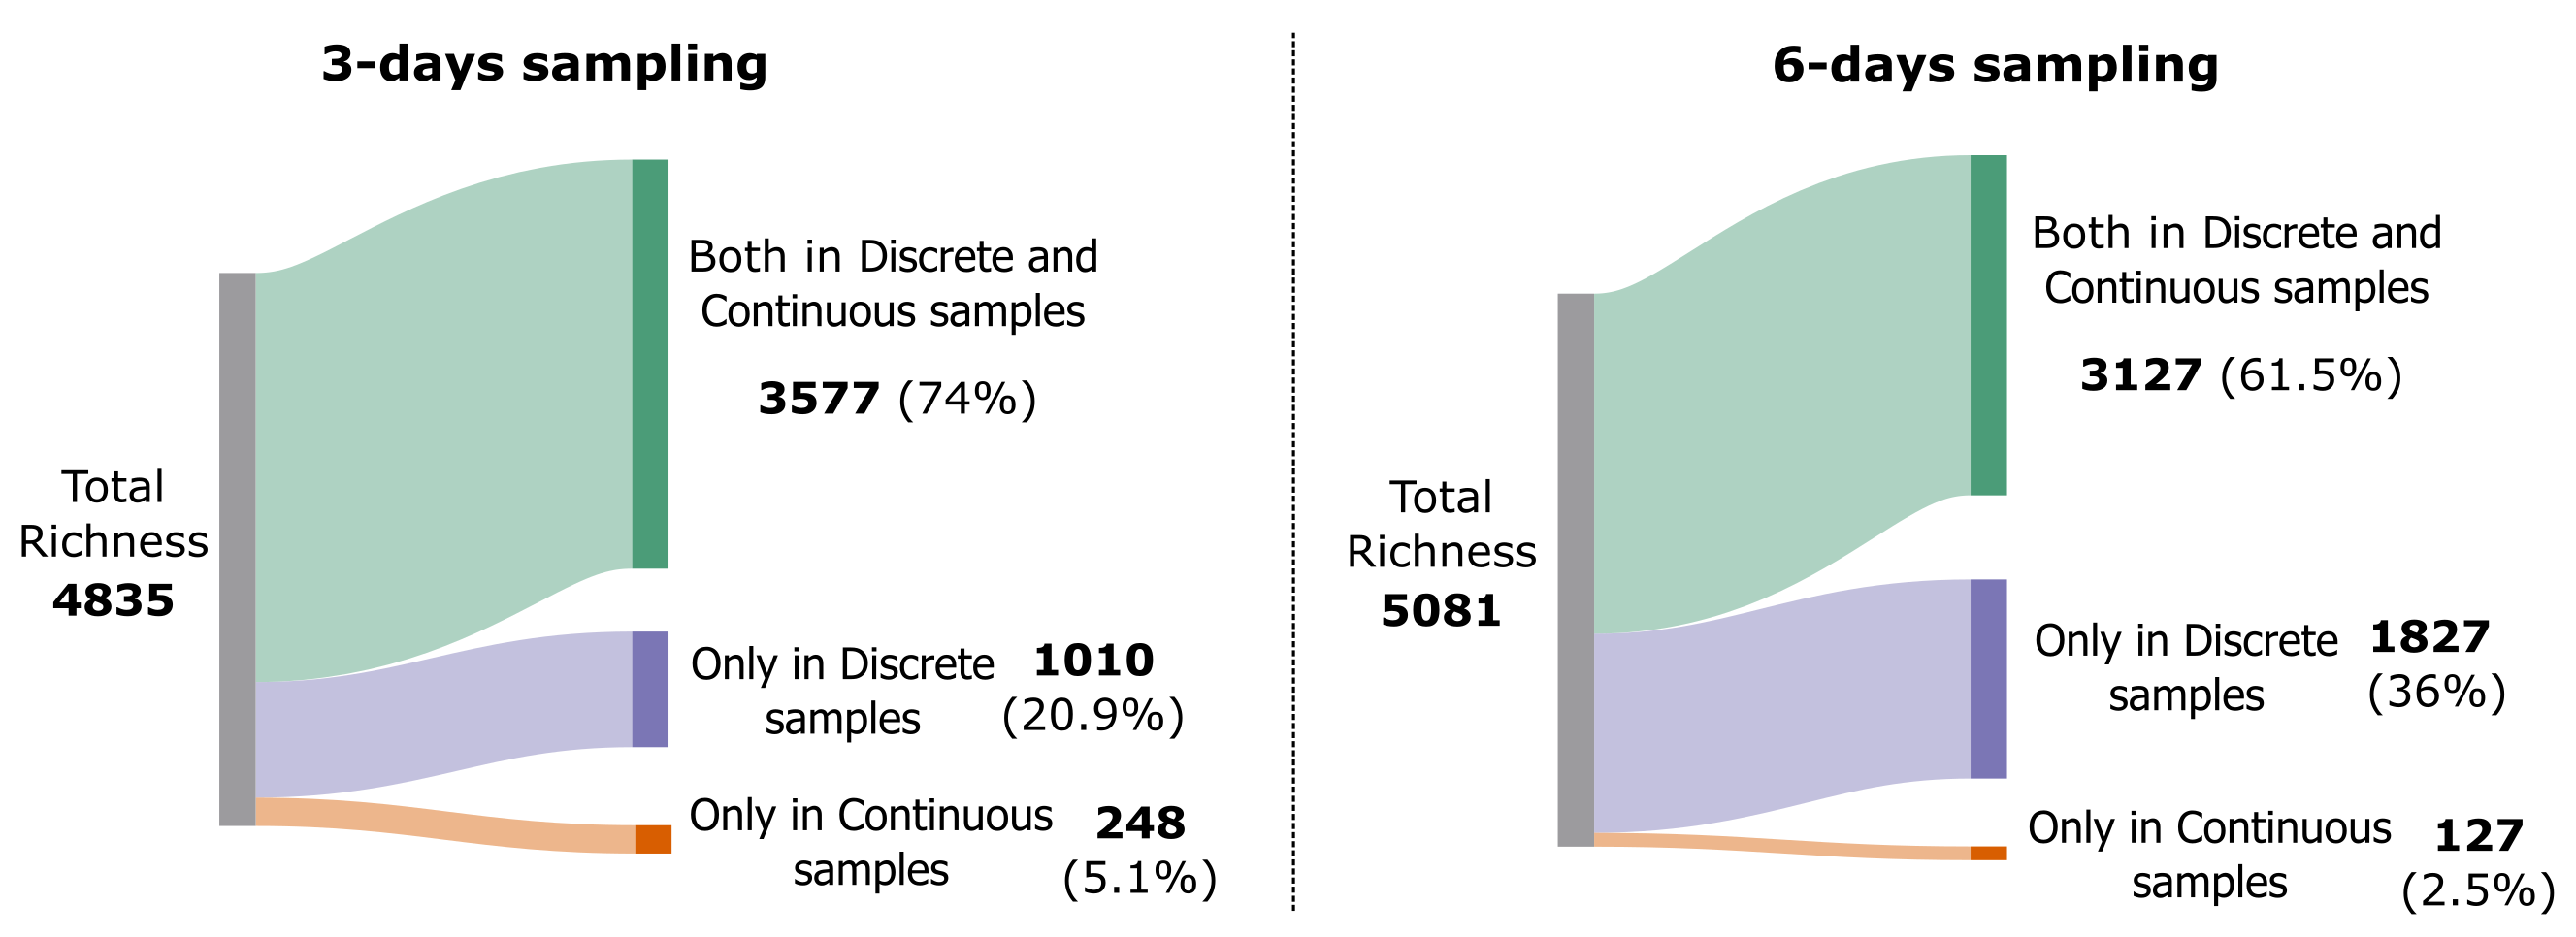

In [11]:
#| code-fold: true
Image('../output/sankey_3d_vs_6d.png')

### Experiment 2: PM10 vs PM2.5 heads 

If we take a look now at the 3 daily samples taken with a PM10 head and the 3 daily samples taken with a PM2.5 head, and where the species identified appear:

In [12]:
#| code-fold: true

(species_long
.merge(metadata_df[['Sampling', 'Sample ID', 'sample_id']])
.rename(columns={'Sample ID': 'sample_code'})
.loc[lambda dd: dd.sample_code.str.contains('PM')]
.loc[lambda dd: dd.sample_code.str.endswith('-B')]
.loc[lambda dd: dd.sample_code.str.contains('.1.', regex=False)]
.assign(header=lambda dd: np.where(dd.sample_code.str.contains("2.5", regex=False),
                                   'PM2.5', 'PM10'
                                   ))
.query('reads > 0')
.pivot_table(index=['name'], columns='header', values='reads', aggfunc='sum')
.assign(presence=lambda dd: np.where(dd['PM10'].isna(), 'PM2.5',
                            np.where(dd['PM2.5'].isna(), 'PM10', 'Both')))
.presence.value_counts()
)

presence
Both     3634
PM10      841
PM2.5     740
Name: count, dtype: int64

We see that in this case, from a total of 5215 species, 3634 appear in both types 
of samples, 841 are unique to PM10 samples and 740 are unique to PM2.5 samples.

I am going to now generate a table listing the species unique to each sample type 
and the count of unique samples where they appear. The formatted tables can be 
accessed [here](https://docs.google.com/spreadsheets/d/1Z2mpG_UcF1rGa4fqV-FreewOr0SFzgNETQ_teDca9Qc/edit?usp=sharing).

In [13]:
#| code-fold: true
uniquely_unique = (species_long
.merge(metadata_df[['Sampling', 'Sample ID', 'sample_id']])
.rename(columns={'Sample ID': 'sample_code'})
.query('name not in @contamination_list')
.loc[lambda dd: dd.sample_code.str.contains('PM')]
.loc[lambda dd: dd.sample_code.str.endswith('-B')]
.loc[lambda dd: dd.sample_code.str.contains('.1.', regex=False)]
.assign(header=lambda dd: np.where(dd.sample_code.str.contains("2.5", regex=False),
                                   'PM2.5', 'PM10'
                                   ))
.query('reads > 0')
.groupby(['name', 'header'])
.size()
.rename('n_present')
.reset_index()
.pivot(index='name', columns='header', values='n_present')
.fillna(0)
.astype(int)
.query('`PM2.5`==0 or `PM10`==0')
.query('`PM2.5`>=1 or `PM10`>=1')
.index
.values
)

unique_pm_reads = (species_long
.merge(metadata_df[['Sampling', 'Sample ID', 'sample_id']])
.rename(columns={'Sample ID': 'sample_code'})
.query('name not in @contamination_list')
.loc[lambda dd: dd.sample_code.str.contains('PM')]
.loc[lambda dd: dd.sample_code.str.endswith('-B')]
.loc[lambda dd: dd.sample_code.str.contains('.1.', regex=False)]
.assign(header=lambda dd: np.where(dd.sample_code.str.contains("2.5", regex=False),
                                   'PM2.5', 'PM10'
                                   ))
.query('reads > 0')
.query('name in @uniquely_unique')
.groupby(['name', 'header'])
.agg({'reads': sum, 'sample_code': 'nunique'})
.reset_index()
)

(unique_pm_reads
 .pivot(index='name', columns='header')
 .fillna(0)
 .astype(int)
).to_csv('../output/table_unique_species_pm.csv')


/var/folders/st/cmjs4m0d5_x9cct52wfljtvm0000gn/T/ipykernel_34421/2888628616.py:39: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


If we check the total reads assigned per sample day and head type, we observe that while for days 1 and 2 the total reads where rather high and similar for both head types, but the 3rd day had a strong reduction, with the PM2.5 head having a much lower number of reads than the PM10 head (which still had a low number of reads compared to the previous two days).

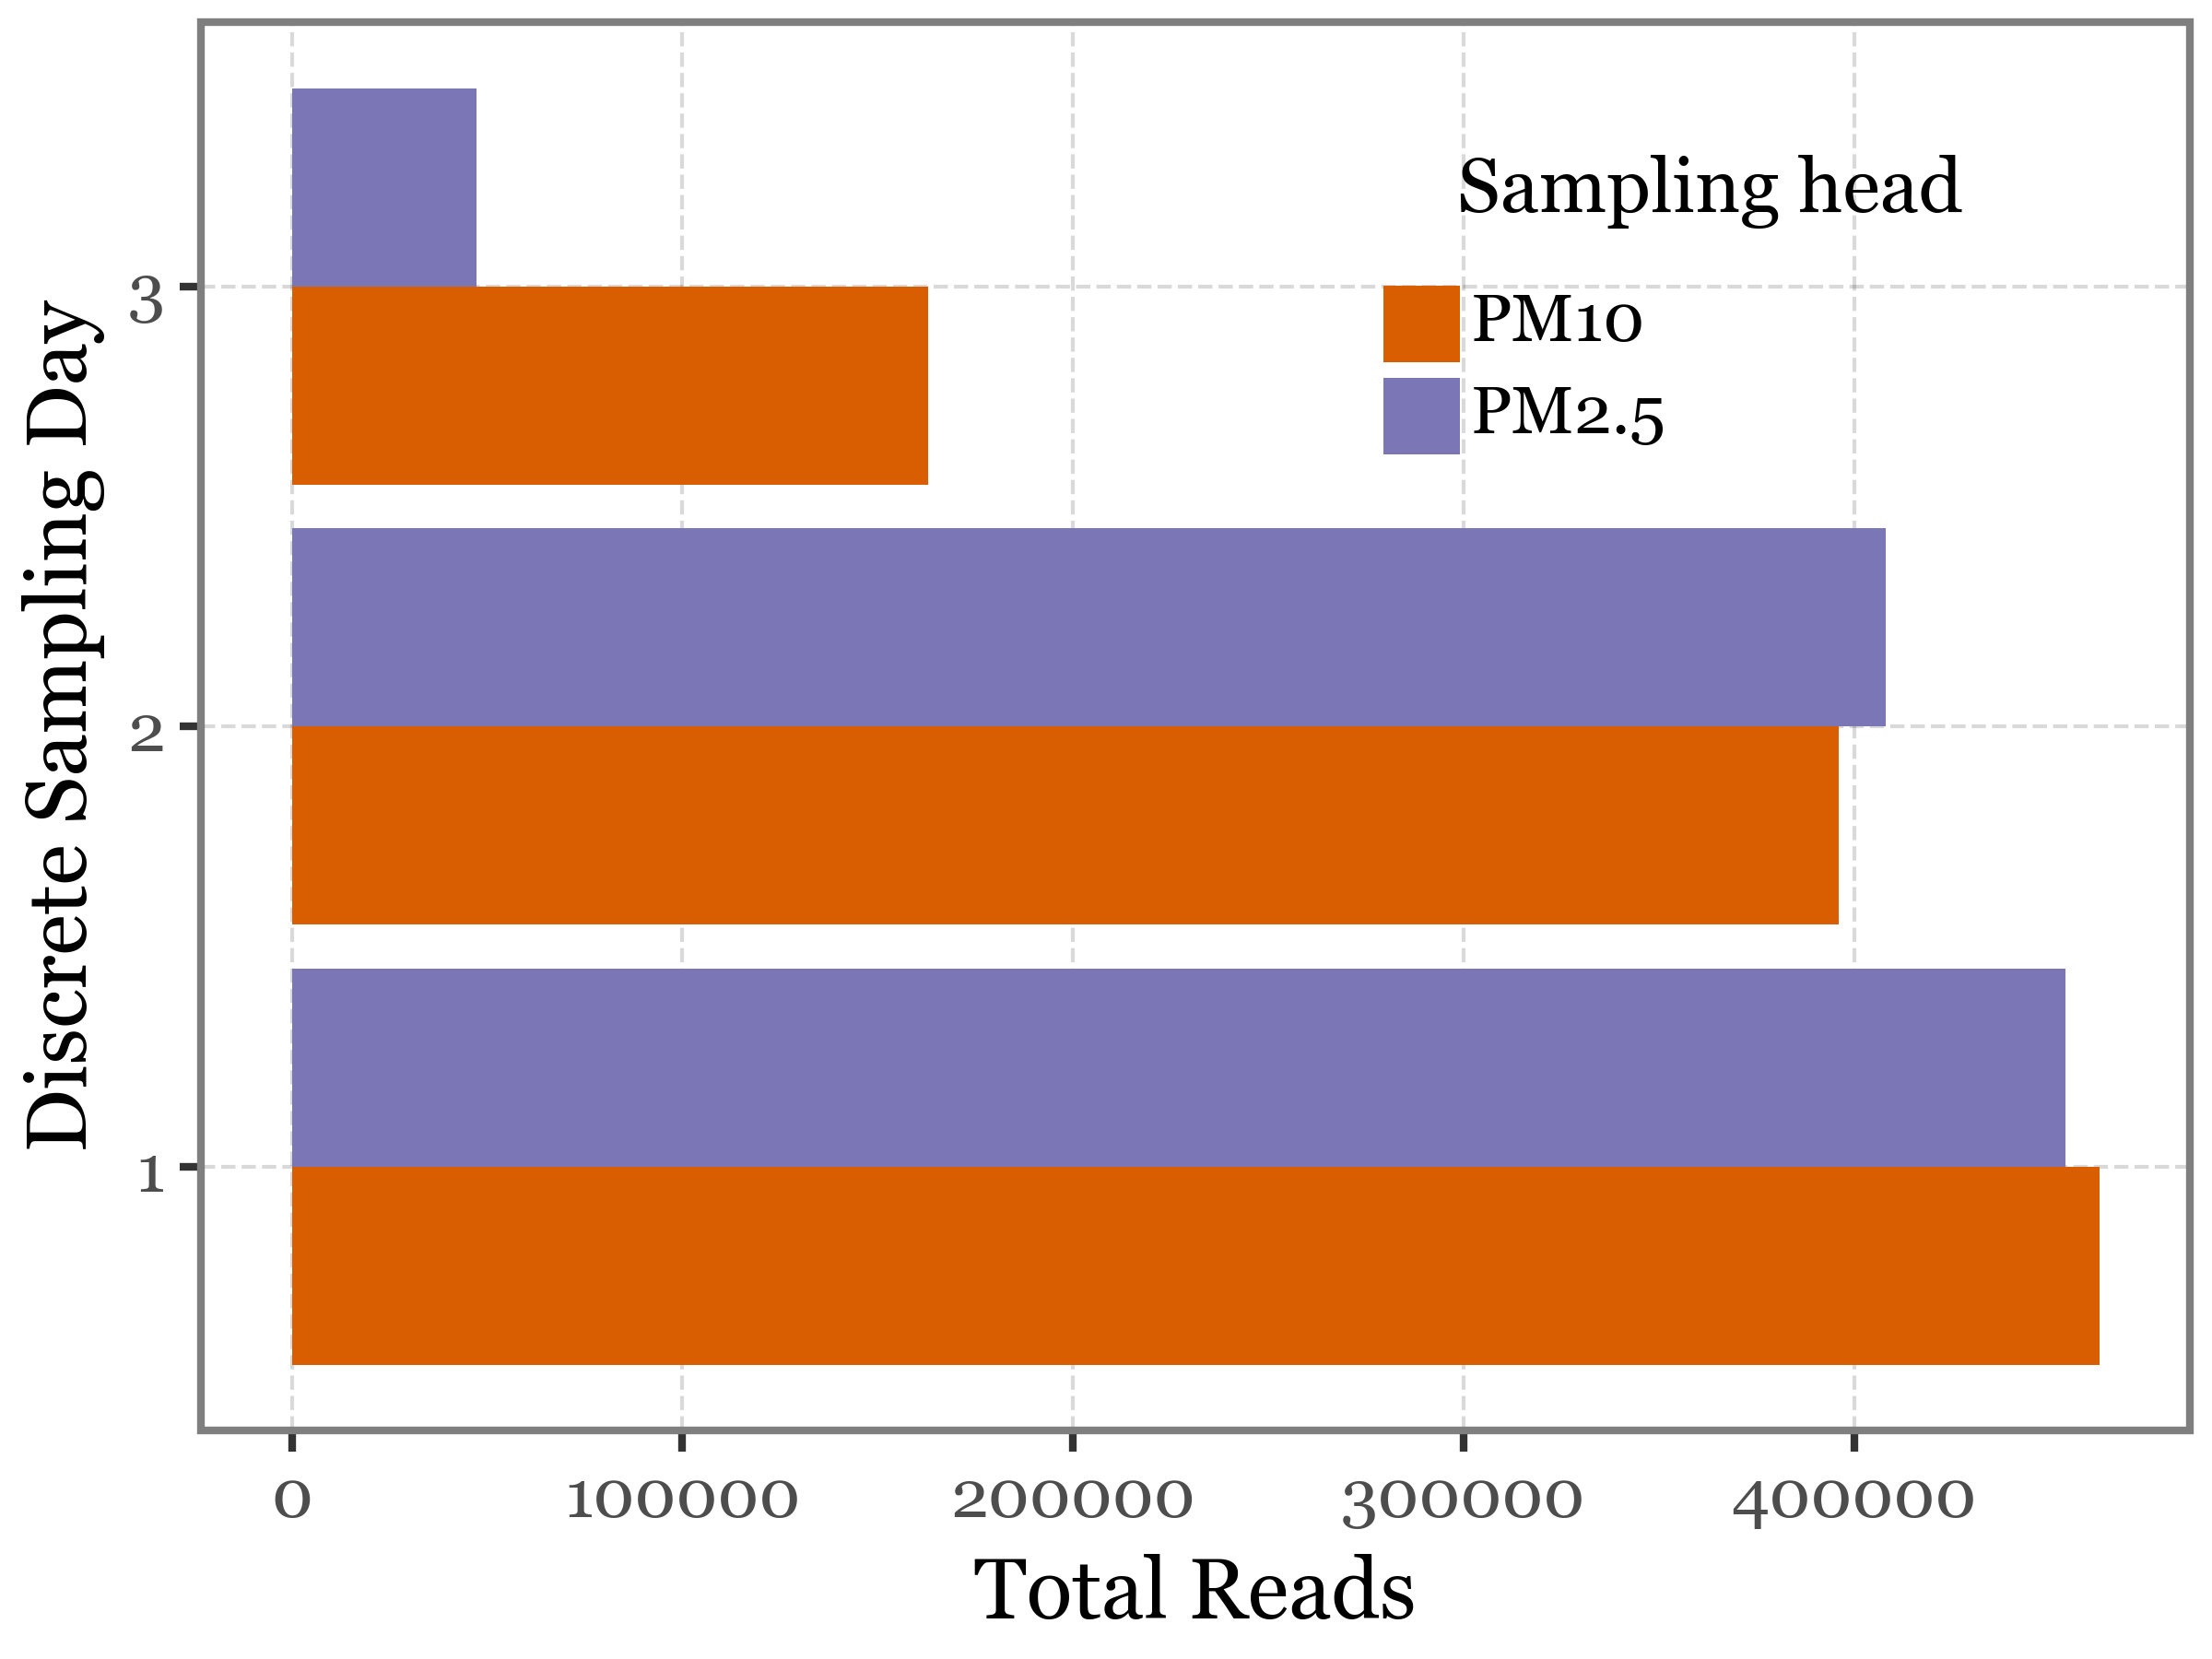

In [14]:
#| code-fold: true
(species_long
.merge(metadata_df[['Sampling', 'Sample ID', 'sample_id']])
.rename(columns={'Sample ID': 'sample_code'})
.query('name not in @contamination_list')
.loc[lambda dd: dd.sample_code.str.contains('PM')]
.loc[lambda dd: dd.sample_code.str.endswith('-B')]
.loc[lambda dd: dd.sample_code.str.contains('.1.', regex=False)]
.assign(header=lambda dd: np.where(dd.sample_code.str.contains("2.5", regex=False),
                                   'PM2.5', 'PM10'
                                   ))
.query('reads > 0')
.groupby(['header', 'sample_code'])
.reads.sum()
.reset_index()
.assign(sample_code=lambda dd: dd.sample_code.str.split('-').str[0])
.assign(day=lambda dd: dd.sample_code.str.split('.').str[-1])
.pipe(lambda dd: p9.ggplot(dd)
      + p9.aes('day', 'reads', fill='header')
      + p9.geom_col(position='dodge')
      + p9.coord_flip()
      + p9.scale_fill_manual(['#D85E01', '#7B76B5'])
      + p9.labs(x='Discrete Sampling Day', y='Total Reads', fill='Sampling head')
      + p9.theme(
          figure_size=(4, 3),
          legend_position=(.8, .85),
          legend_key_size=10,
          legend_title=p9.element_text(x=80, y=50, size=10)
          )
      )
)

If we focus on the species which are not only unique to each head type but that are
present with higher relative weight in one of the head types, we can see the top 50
most differentiallly abundant species here (based on the diffs between the relative 
abundance of the species in the two head types):

/var/folders/st/cmjs4m0d5_x9cct52wfljtvm0000gn/T/ipykernel_34421/62435107.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


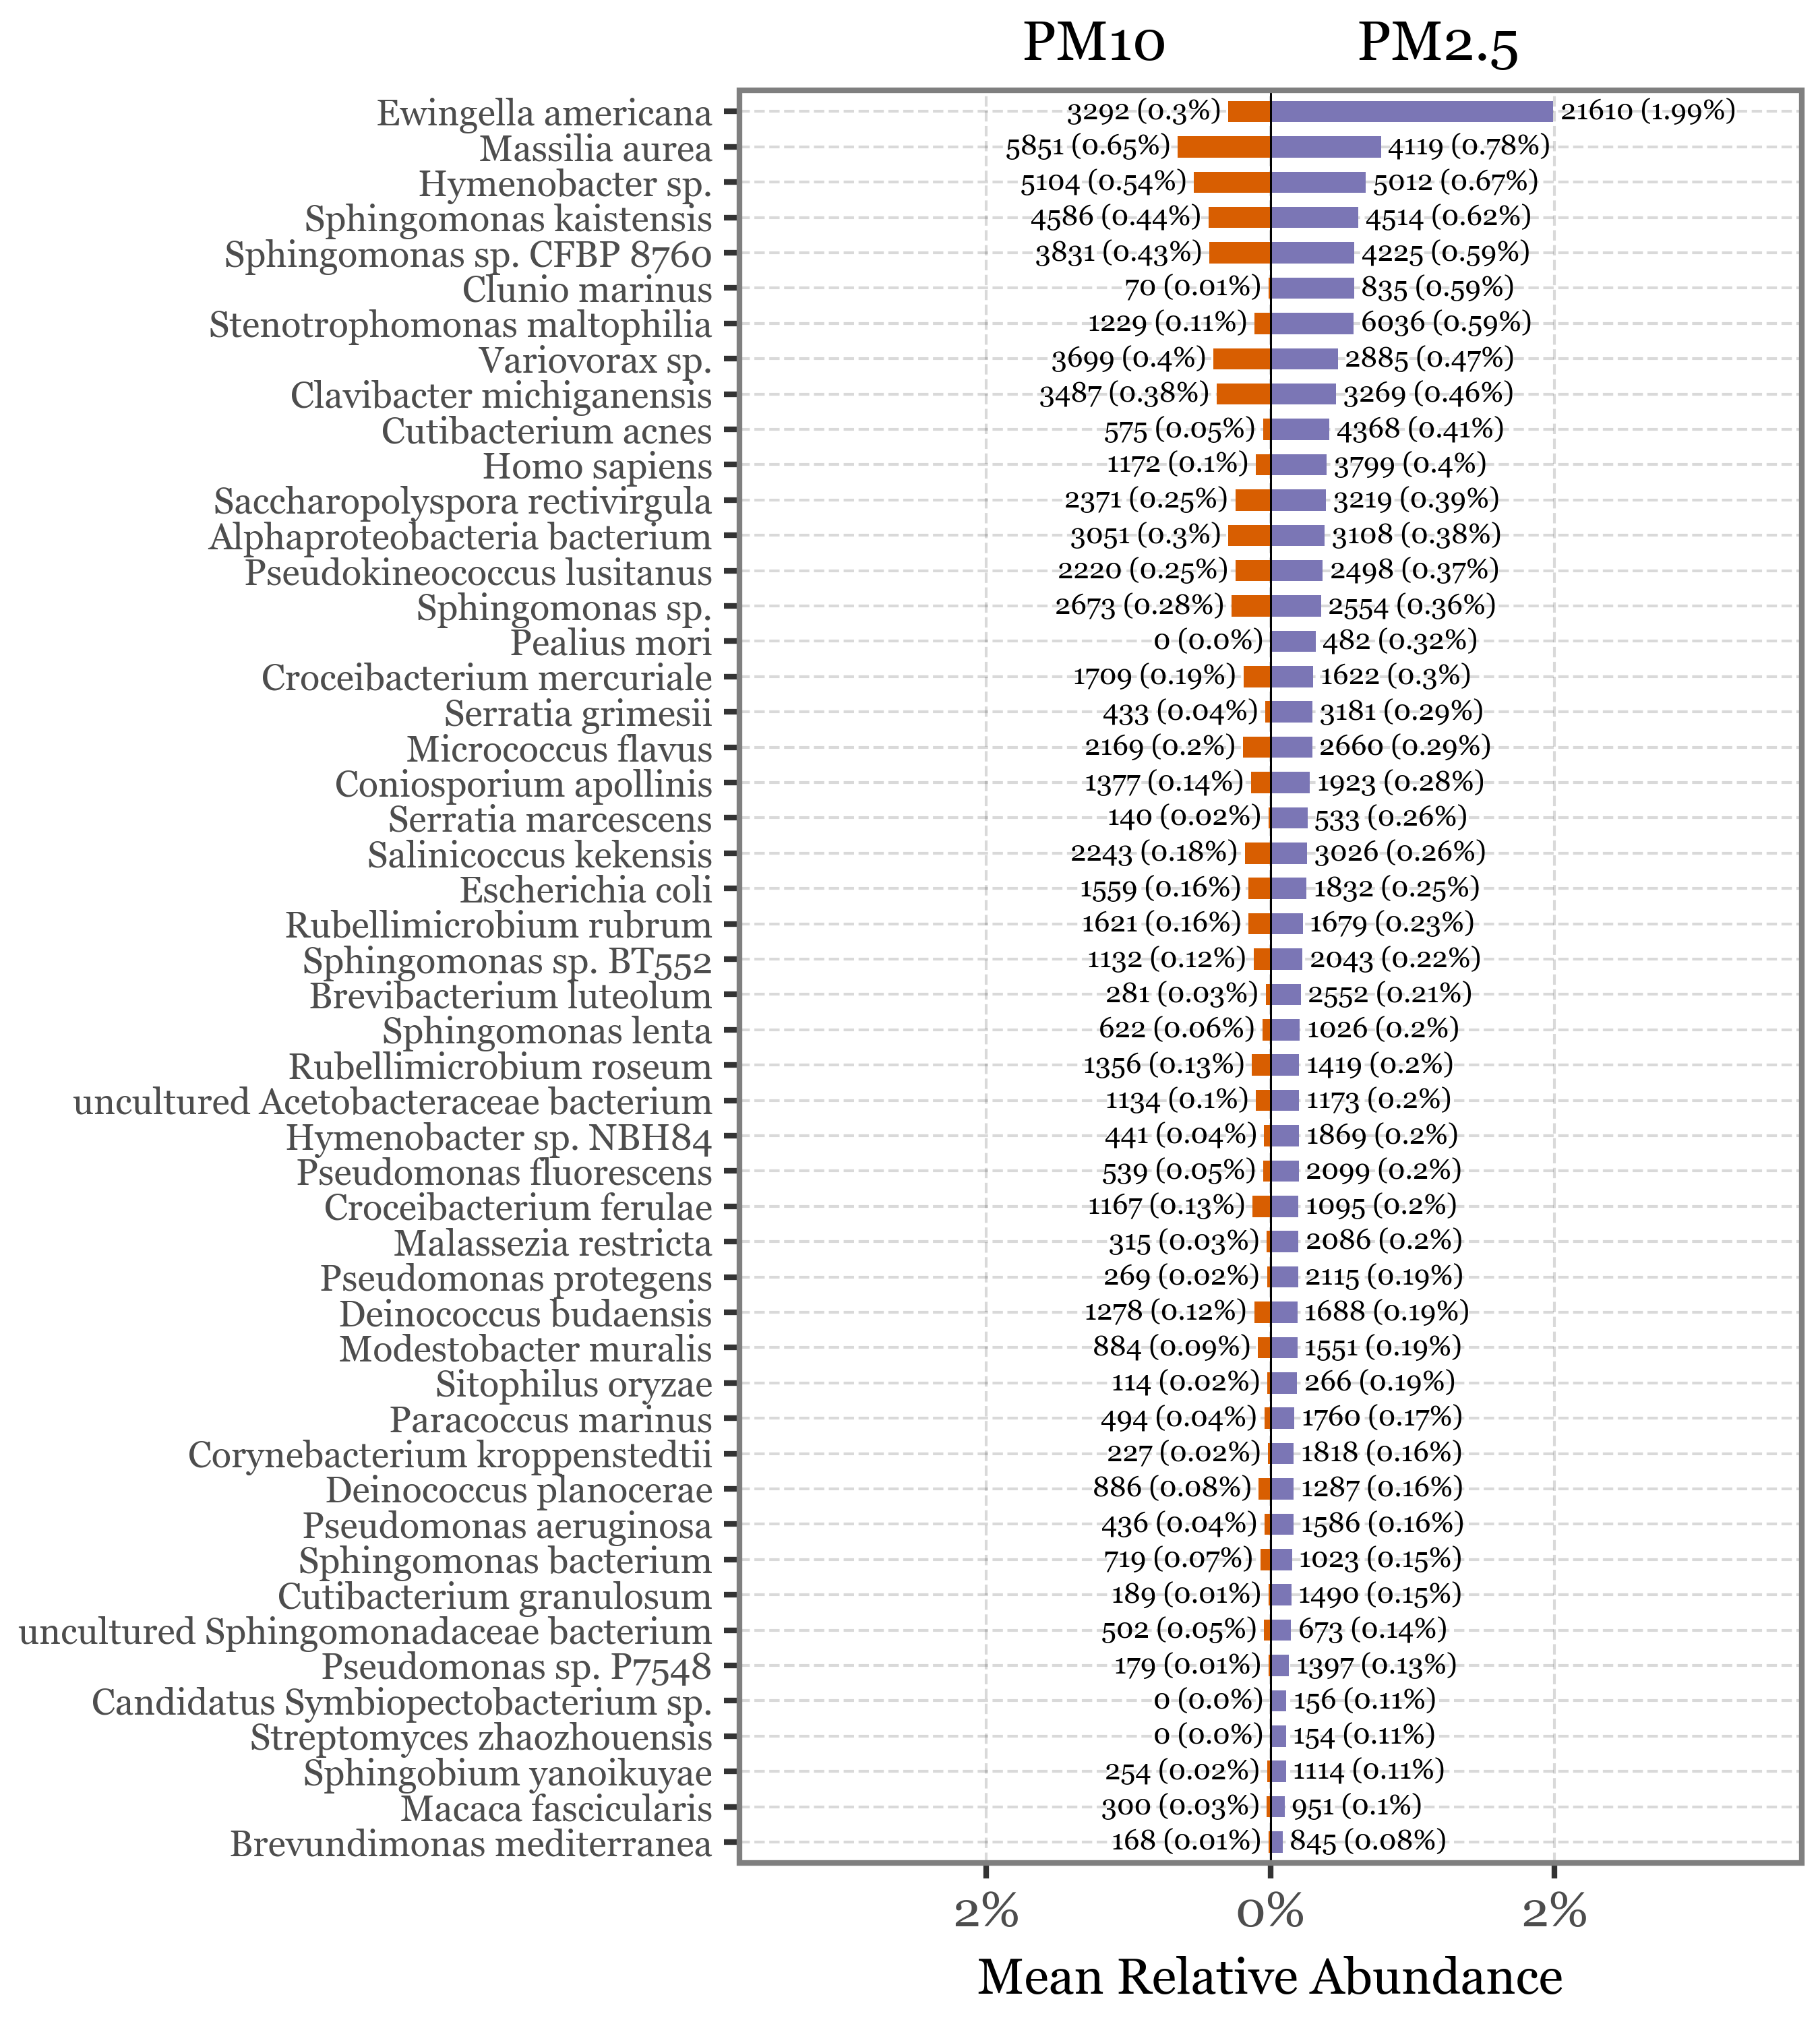

In [17]:
#| code-fold: true

species_by_header = (species_long
.merge(metadata_df[['Sampling', 'Sample ID', 'sample_id']])
.rename(columns={'Sample ID': 'sample_code'})
.query('name not in @contamination_list')
.loc[lambda dd: dd.sample_code.str.contains('PM')]
.loc[lambda dd: dd.sample_code.str.endswith('-B')]
.loc[lambda dd: dd.sample_code.str.contains('.1.', regex=False)]
.assign(header=lambda dd: np.where(dd.sample_code.str.contains("2.5", regex=False),
                                   'PM2.5', 'PM10'
                                   ))
.groupby(['header', 'sample_code'], as_index=False)
.apply(lambda dd: dd.assign(rel_abundance=lambda x: x['reads'] / x['reads'].sum()))
.reset_index(drop=True)
.groupby(['name', 'header'])
.agg({'rel_abundance': lambda x: x.sum() / 3, 'reads': 'sum'})
.loc[lambda x: x.reads > 0]
.reset_index()
.pivot(index='name', columns='header', values=['rel_abundance', 'reads'])
.fillna(0)
.assign(diff=lambda dd: (dd[('rel_abundance',  'PM2.5')] - dd[('rel_abundance',  'PM10')]))
.assign(direction=lambda dd: np.where(dd['diff'] > 0, 'PM2.5 > PM10', 'PM2.5 < PM10'))
.assign(abs_diff=lambda dd: dd['diff'].abs())
.sort_values('diff', ascending=False)
.head(50)
.assign(reads_label=lambda dd: 
        dd['reads', 'PM10'].astype(int).astype(str) + ':' + 
        dd['reads', 'PM2.5'].astype(int).astype(str))
.reset_index()
.assign(direction=lambda dd: 
        pd.Categorical(dd.direction, categories=['PM2.5 > PM10', 'PM2.5 < PM10'],
                       ordered=True)
)
 .replace({"Candidatus Symbiopectobacterium sp. 'North America'":
           "Candidatus Symbiopectobacterium sp."})
)

sorted_species_rel = species_by_header.sort_values(('rel_abundance', 'PM2.5'))['name']
sorted_species_reads = species_by_header.sort_values(('reads', 'PM10'))['name']

species_by_header.columns = ['_'.join(col).strip() for col in species_by_header.columns.values]
(species_by_header
 .assign(rel_abundance_PM10=lambda dd: dd['rel_abundance_PM10'] * - 1)
 .assign(label_pm25=lambda dd: dd['reads_PM2.5'].astype(int).astype(str) +  ' ('
         + (dd['rel_abundance_PM2.5'] * 100).round(2).astype(str) + '%)')
 .assign(label_pm10=lambda dd: dd['reads_PM10'].astype(int).astype(str) +  ' ('
         + (dd['rel_abundance_PM10'].abs() * 100).round(2).astype(str) + '%)')
.assign(name=lambda dd: pd.Categorical(dd.name_, categories=sorted_species_rel, ordered=True))
.pipe(lambda dd: p9.ggplot(dd) 
      + p9.aes('name')
      + p9.coord_flip() 
      + p9.geom_col(p9.aes(y='rel_abundance_PM2.5'), fill='#7B76B5', width=.6)
      + p9.geom_col(p9.aes(y='rel_abundance_PM10'), fill='#D85E01', width=.6)
      + p9.geom_text(p9.aes(label='label_pm10', y='rel_abundance_PM10'),
                      size=5, ha='right', nudge_y=-.0005)
      + p9.geom_text(p9.aes(label='label_pm25', y='rel_abundance_PM2.5'),
                      size=5, ha='left', nudge_y=.0005)
      + p9.scale_y_continuous(
          labels=["2%", "0%", "2%"],
          limits=[-.034, .034])
      + p9.annotate('hline', yintercept=0, linetype='solid', size=.2)
      + p9.labs(x='', y='Mean Relative Abundance', title=f'PM10              PM2.5')
      + p9.theme(figure_size=(4.5, 5),
                 axis_text_y=p9.element_text(size=6.5),
                 axis_title_x=p9.element_text(size=9),
                 plot_title=p9.element_text(size=10, ha='center'),
                 )
      )
)

If we instead focus on the species that appear in at least 2 samples of one head type and
none of the other, the top 30 for each head type are:

/var/folders/st/cmjs4m0d5_x9cct52wfljtvm0000gn/T/ipykernel_34421/3412388089.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 7 in image.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../output/unique_pm_species.svg


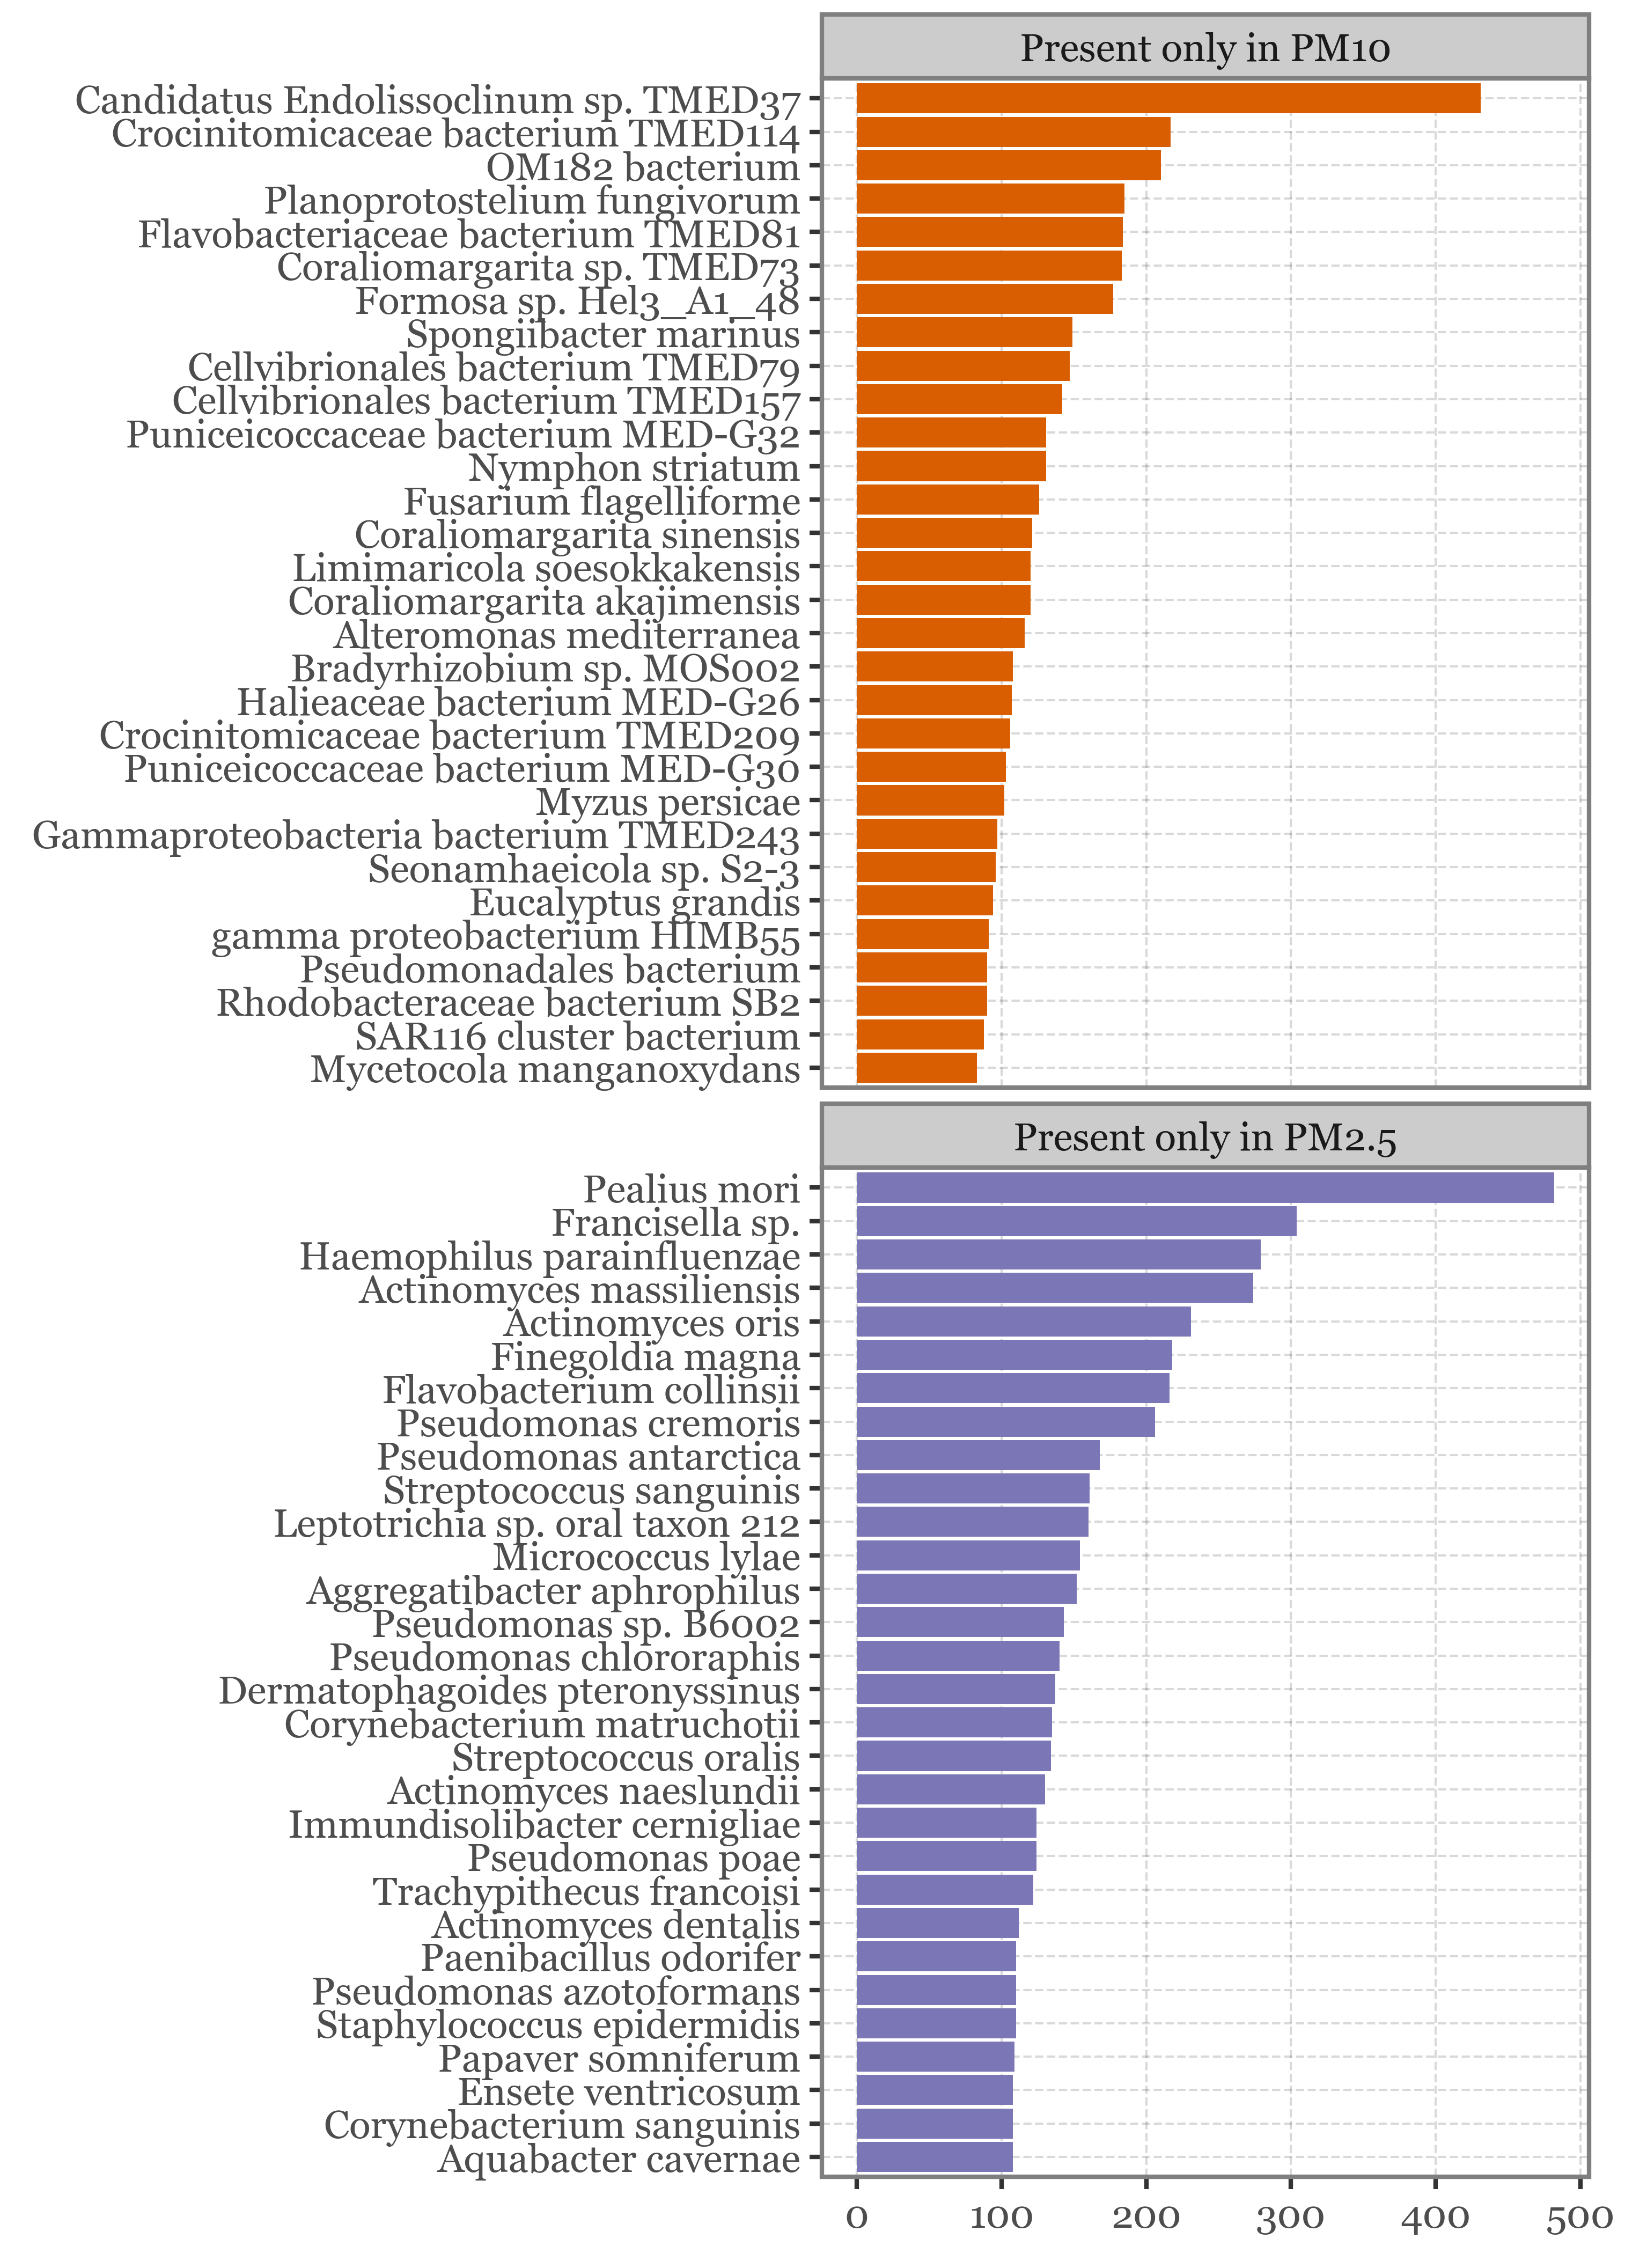

In [19]:
#| code-fold: true
f = (unique_pm_reads
     .query('sample_code >= 2')
 .groupby('header')
 .apply(lambda dd: dd
        .sort_values('reads', ascending=False)
        .reset_index(drop=True)
        .assign(rank=lambda x: x.index + 1)
        )
 .reset_index(drop=True)
 .query('rank <= 30')
 .replace({'PM10': 'Present only in PM10', 'PM2.5': 'Present only in PM2.5'})
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('reorder(name, reads)', 'reads')
       + p9.geom_col(p9.aes(fill='header'))
       + p9.facet_wrap('header', scales='free_y', ncol=1)
       + p9.coord_flip()
       + p9.labs(x='', y='')
       + p9.scale_fill_manual(['#D85E01', '#7B76B5'])
       + p9.guides(fill=False)
       + p9.theme(figure_size=(5, 7))
       
       )
)

f.save('../output/unique_pm_species.svg', dpi=300)
f.draw()

If we go ahead and test whether the richness of species is different between the two head types, we can do a non-parametric paired test (Wilcoxon signed-rank test) to compare the richness of species between the two head types:

In [20]:
#| code-fold: true

pm_richness = (species_long
.merge(metadata_df[['Sampling', 'Sample ID', 'sample_id']])
.rename(columns={'Sample ID': 'sample_code'})
.query('name not in @contamination_list')
.loc[lambda dd: dd.sample_code.str.contains('PM')]
.loc[lambda dd: dd.sample_code.str.endswith('-B')]
.loc[lambda dd: dd.sample_code.str.contains('.1.', regex=False)]
.assign(header=lambda dd: np.where(dd.sample_code.str.contains("2.5", regex=False),
                                   'PM2.5', 'PM10'
                                   ))
.query('reads > 0')
.groupby(['header', 'sample_code'])
['name']
.nunique()
.reset_index()
.assign(day=lambda dd: dd.sample_code.str.split('.').str[-1])
.pivot(index='day', columns='header', values='name')
.assign(diff=lambda dd: (dd['PM2.5'] - dd['PM10']))
)

pm_richness

header  PM10  PM2.5  diff
day                      
1-B     3682   3626   -56
2-B     3019   3232   213
3-B     1599    642  -957

The results of the test show a non-significant difference in the richness of species between the two head types (p-value = 0.75).

In [21]:
stats.wilcoxon(pm_richness['diff'])

WilcoxonResult(statistic=2.0, pvalue=0.75)

### Supp. Experiment: Bags vs Vial blanks

We are going to compare the richness of the blanks using vials and bags to see if there is a significant difference between the two types of blanks:

In [22]:
bag_vial_blanks = ['B6-B', 'B6-V', 'B3-B', 'BPM-B', 'B3-V', 'BPM-V', 'BQZ-B', 'BQZ-V']

In [23]:
blanks_table = pd.read_csv('../data/ABS_hvs_blank2-sp.csv')
blanks_table.columns = [col.split('.')[0] for col in blanks_table.columns]
blanks_table.rename(columns={'#Datasets': 'name'}, inplace=True)


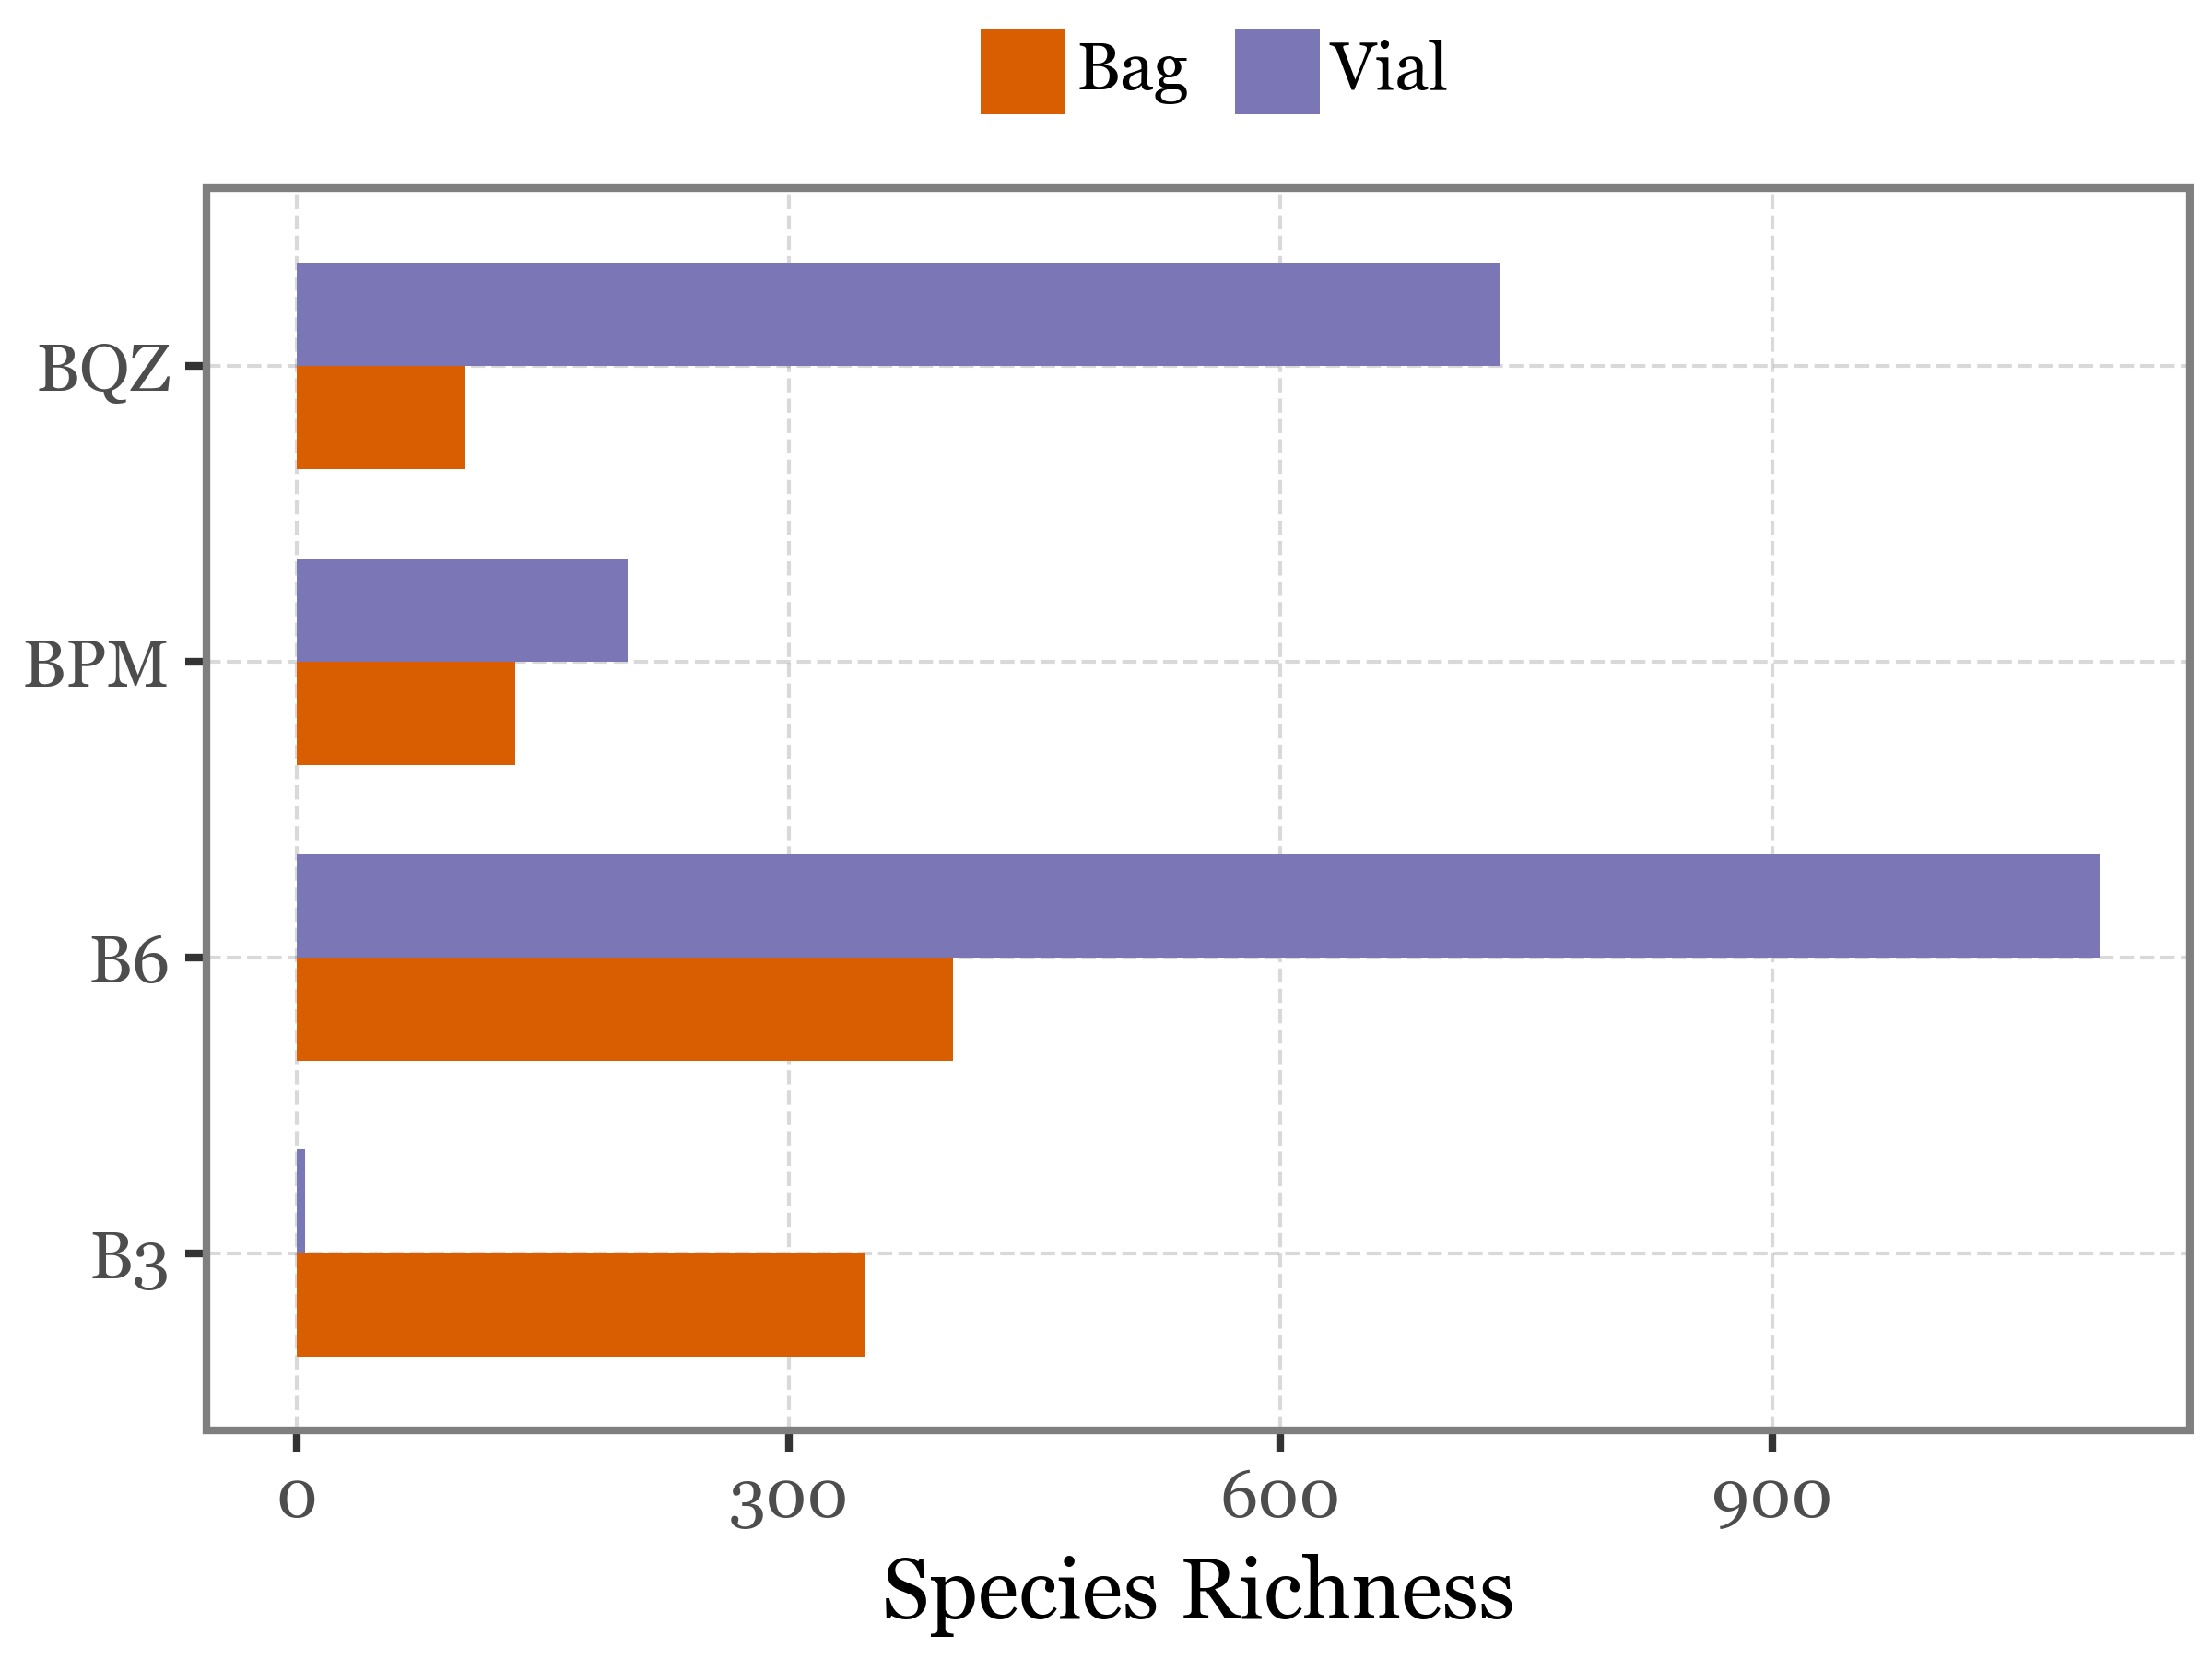

In [24]:
#| code-fold: true

blanks_richness =(blanks_table
 .melt('name', var_name='sample_id', value_name='reads')
 .merge(metadata_df[['Sample ID', 'sample_id']])
 .query('`Sample ID` in @bag_vial_blanks')
 .assign(kind=lambda dd: dd['Sample ID'].str.split('-').str[1]
         .replace({'B': 'Bag', 'V': 'Vial'}))
 .assign(sample_name=lambda dd: dd['Sample ID'].str.split('-').str[0])
 .query('reads > 0')
 .groupby(['sample_name', 'kind'])
 .agg({'name': 'nunique'})
 .reset_index()
)

(blanks_richness
 .pipe(lambda dd: p9.ggplot(dd)
        + p9.aes('sample_name', 'name', fill='kind')
        + p9.geom_col(position='dodge', width=.7)
        + p9.coord_flip()
        + p9.labs(x='', y='Species Richness', fill='')
        + p9.scale_fill_manual(['#D85E01', '#7B76B5'])
        + p9.theme(figure_size=(4, 3),
                   legend_position='top',
                   legend_key_size=11,
                   )
       )
)

There is no significant difference when testing with a Wilcoxon signed-rank test (p-value = 0.375):

### Shannon and Simpson diversity indexes

We are now going to compute the Shannon and Simpson diversity indexes for the blanks.


The Shannon diversity index  H  is given by the formula:

 $$H = -\sum_{i=1}^{R} p_i \ln(p_i)$$

where:

+	 $R$  is the total number of species,
+	 $p_i$  is the proportion of individuals belonging to the  $i$-th species, calculated as  $p_i = \frac{n_i}{N}$ ,
+	 $n_i$  is the number of individuals in the  i -th species,
+	 $N$  is the total number of individuals across all species.

The Simpson diversity index  D  can then be defined as:

 $$D = 1 - \sum_{i=1}^{R} p_i^2  = 1 - \frac{\sum_{i=1}^{R} n_i (n_i - 1)}{N (N - 1)} $$


 We'll define a function to calculate each of these indexes in numpy and then simply
 apply it to the columns of the dataframe with the species counts to get the diversity
 indexes for each sample:



In [74]:
from typing import List

def shannon_diversity(species_counts: List[int]) -> float:
    species_counts = np.array(species_counts)
    species_counts = species_counts[species_counts > 0]
    total_counts = np.sum(species_counts)
    proportions = species_counts / total_counts
    shannon_index = -np.sum(proportions * np.log(proportions))
    return shannon_index

def simpson_diversity(species_counts: List[int]) -> float:
    species_counts = np.array(species_counts)
    total_counts = np.sum(species_counts)
    proportions = species_counts / total_counts
    simpson_index = 1 - np.sum(proportions ** 2)
    return simpson_index

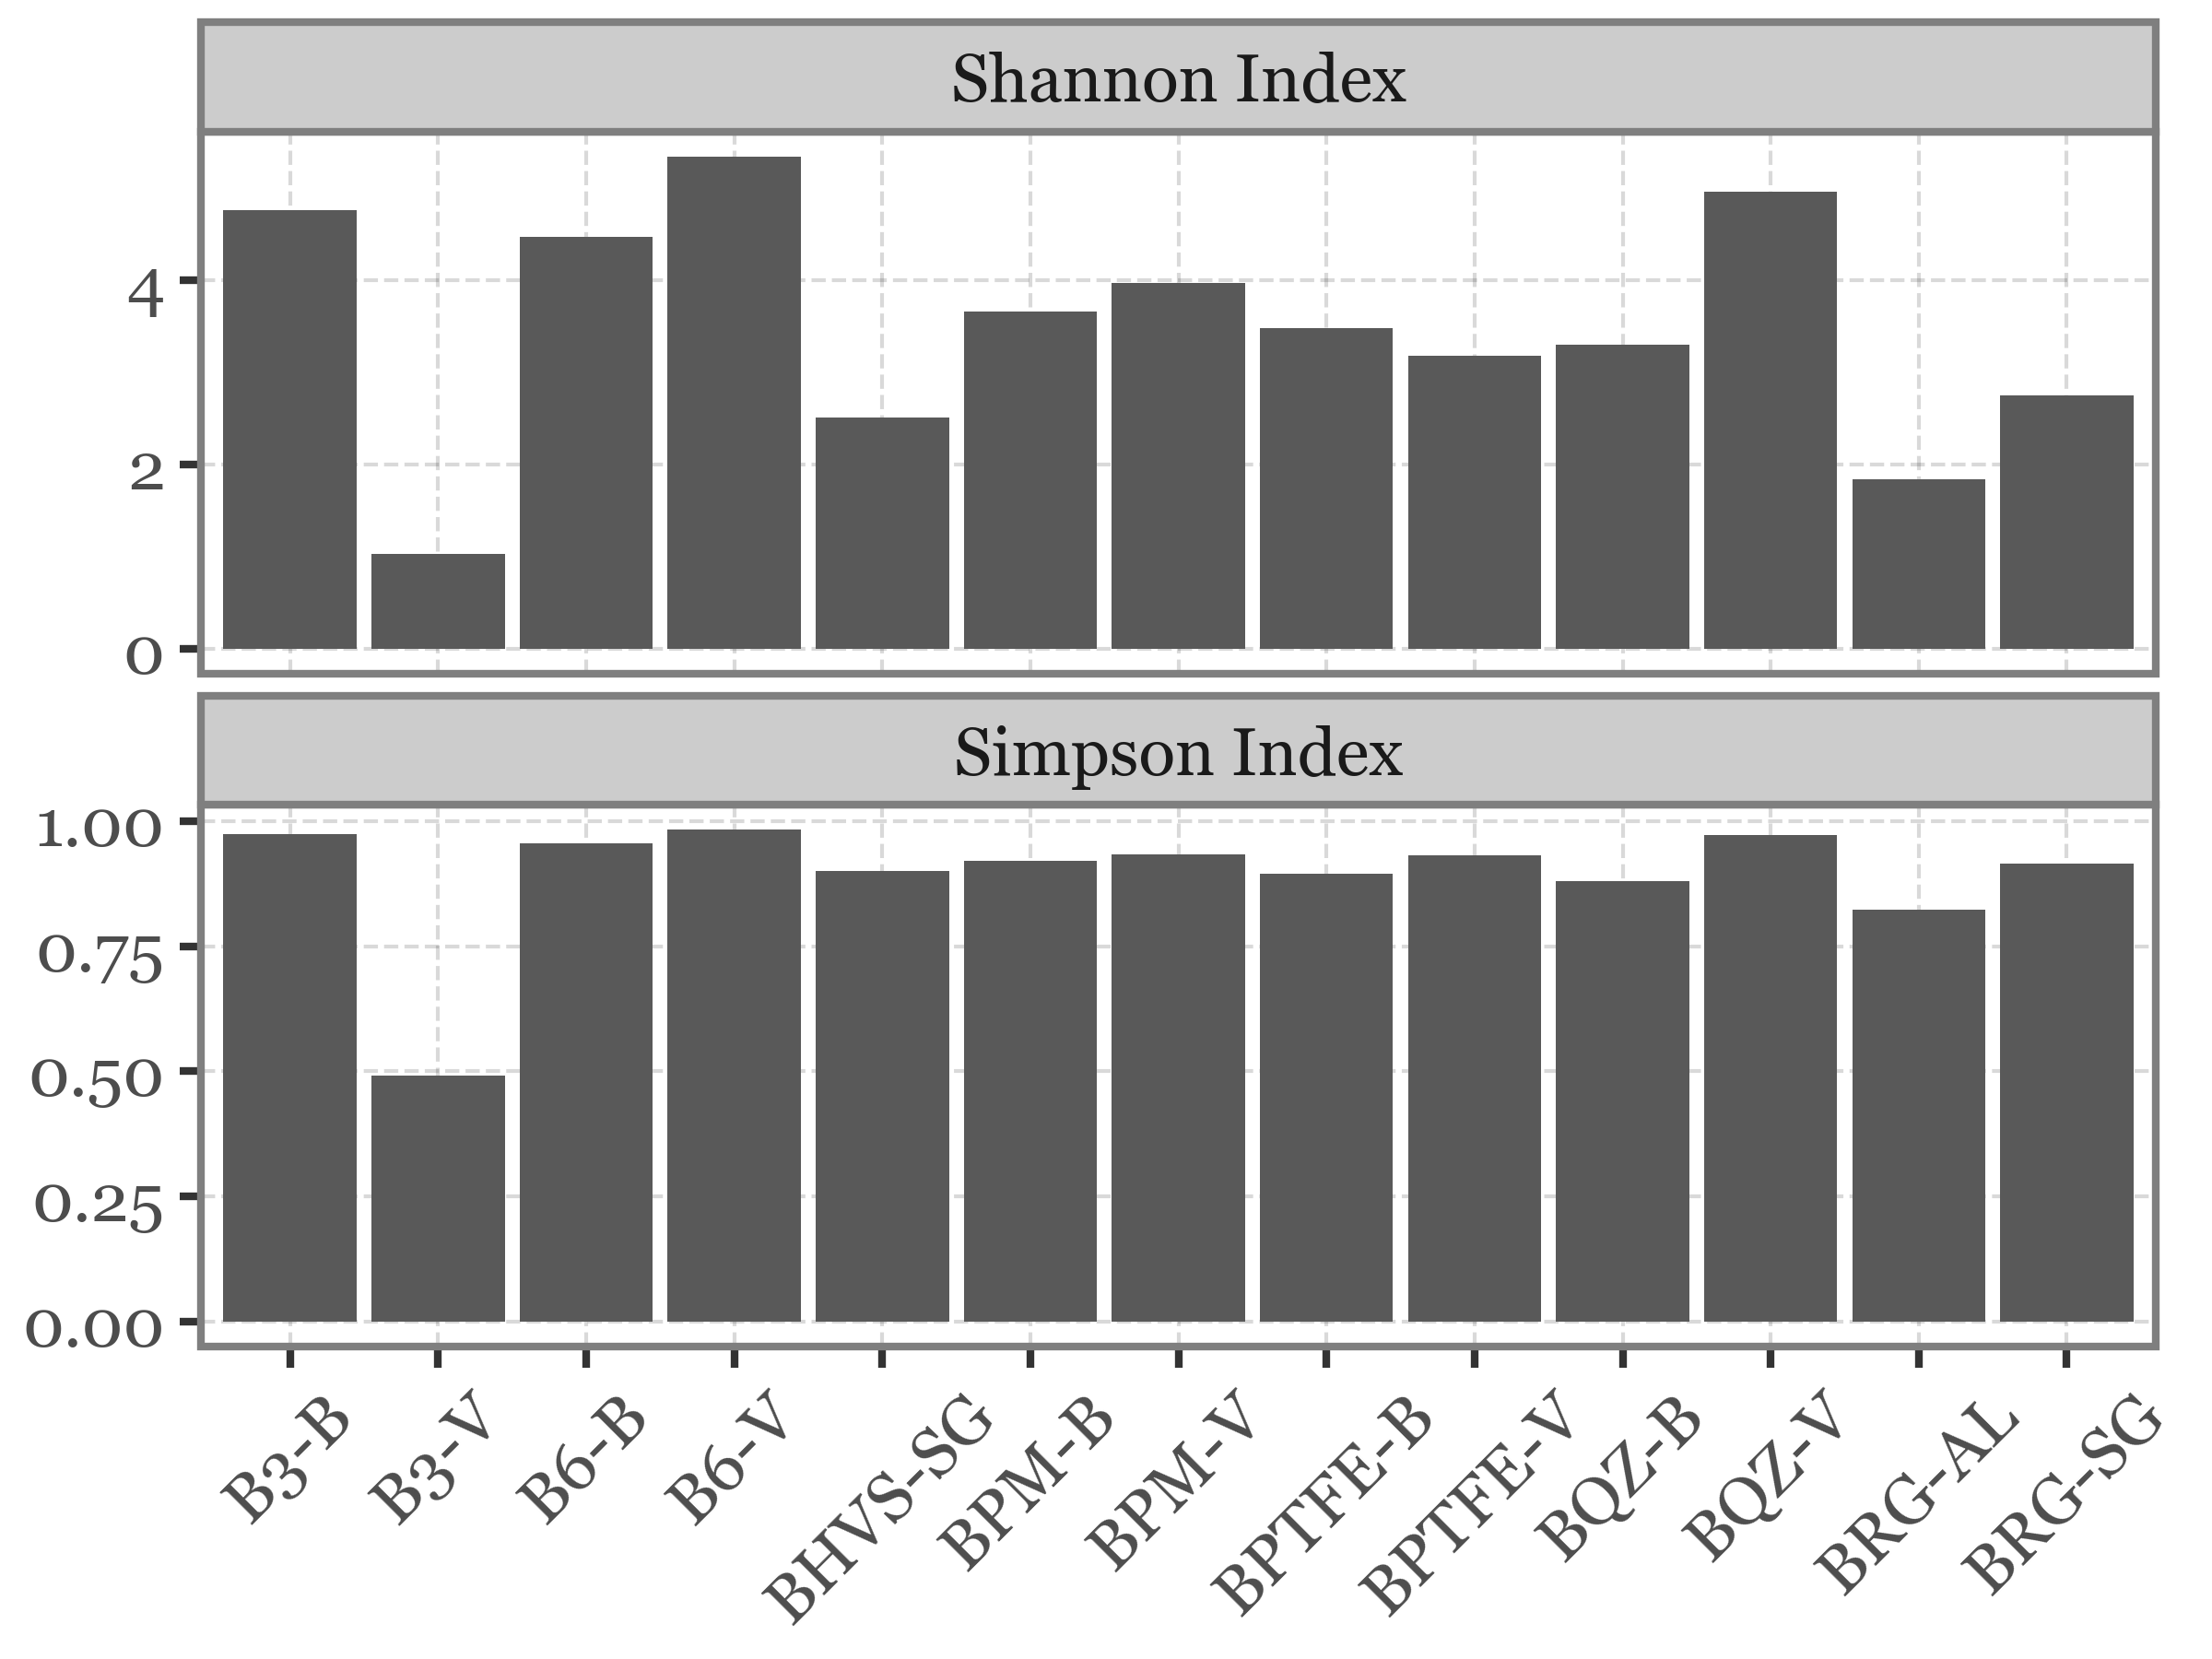

In [101]:
#| code-fold: true

blank_sample_names = metadata_df.loc[metadata_df['Sample ID'].str.startswith('B')]['Sample ID']

(blanks_table
 .melt('name', var_name='sample_id', value_name='counts')
 .merge(metadata_df[['Sample ID', 'sample_id']])
 .query('`Sample ID` in @blank_sample_names')
 .pivot(index='name', columns='Sample ID', values='counts')
 .fillna(0)
 .pipe(lambda dd: pd.concat([
        dd.apply(shannon_diversity, axis=0).rename('Shannon Index').reset_index()
        .merge(dd.apply(simpson_diversity, axis=0).rename('Simpson Index').reset_index())
    ])
 )
 .melt('Sample ID', var_name='index', value_name='value')
 .pipe(lambda dd: p9.ggplot(dd)
       
       + p9.aes('Sample ID', 'value')
       + p9.geom_col()
       + p9.facet_wrap('~index', scales='free_y', ncol=1)
       + p9.labs(x='', y='')
       + p9.theme(figure_size=(4, 3), axis_text_x=p9.element_text(angle=45))
 )
)